## 加载模型


In [1]:
import os
import json
import time
import web
import numpy as np
from PIL import Image
from config import *
from apphelper.image import union_rbox,adjust_box_to_origin,base64_to_PIL
from application import trainTicket,idcard 
if yoloTextFlag =='keras' or AngleModelFlag=='tf' or ocrFlag=='keras':
    if GPU:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)
        import tensorflow as tf
        from keras import backend as K
        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        config.gpu_options.per_process_gpu_memory_fraction = 0.3## GPU最大占用量
        config.gpu_options.allow_growth = True##GPU是否可动态增加
        K.set_session(tf.Session(config=config))
        K.get_session().run(tf.global_variables_initializer())
    
    else:
      ##CPU启动
      os.environ["CUDA_VISIBLE_DEVICES"] = ''

if yoloTextFlag=='opencv':
    scale,maxScale = IMGSIZE
    from text.opencv_dnn_detect import text_detect
elif yoloTextFlag=='darknet':
    scale,maxScale = IMGSIZE
    from text.darknet_detect import text_detect
elif yoloTextFlag=='keras':
    scale,maxScale = IMGSIZE[0],2048
    from text.keras_detect import  text_detect
else:
     print( "err,text engine in keras\opencv\darknet")
     
if DETECTANGLE:
    from text.opencv_dnn_detect import angle_detect
else:
    angle_detect = None

if ocr_redis:
    ##多任务并发识别
    from helper.redisbase import redisDataBase
    ocr = redisDataBase().put_values
else:   
    from crnn.keys import alphabetChinese,alphabetEnglish
    if ocrFlag=='keras':
        from crnn.network_keras import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelKerasLstm
            else:
                ocrModel = ocrModelKerasDense
        else:
            ocrModel = ocrModelKerasEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
            
    elif ocrFlag=='torch':
        from crnn.network_torch import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelTorchLstm
            else:
                ocrModel = ocrModelTorchDense
                
        else:
            ocrModel = ocrModelTorchEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
    elif ocrFlag=='opencv':
        from crnn.network_dnn import CRNN
        ocrModel = ocrModelOpencv
        alphabet = alphabetChinese
    else:
        print( "err,ocr engine in keras\opencv\darknet")
     
    nclass = len(alphabet)+1   
    if ocrFlag=='opencv':
        crnn = CRNN(alphabet=alphabet)
    else:
        crnn = CRNN( 32, 1, nclass, 256, leakyRelu=False,lstmFlag=LSTMFLAG,GPU=GPU,alphabet=alphabet)
    if os.path.exists(ocrModel):
        crnn.load_weights(ocrModel)
    else:
        print("download model or tranform model with tools!")
        
    ocr = crnn.predict_job
    
   
from main import TextOcrModel

model =  TextOcrModel(ocr,text_detect,angle_detect)
from apphelper.image import xy_rotate_box,box_rotate,solve


In [2]:
import cv2
import numpy as np

ft2 = cv2.freetype.createFreeType2()
ft2.loadFontData("/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc", 0)

def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.shape[:2]
        
    else:
        imgH,imgW= img.shape[:2]

    for line in result:
#         print('line:\n', line)
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        blurred_tmp = cv2.GaussianBlur(tmp,(3,3), 17)
        mask = np.zeros((imgH, imgW, 3), dtype=np.uint8)
        cv2.rectangle(mask, (int(x1), int(y1)), (int(x3), int(y3)),
                      color=(255, 255, 255), thickness=-1)
        tmp = np.where(mask==np.array([255, 255, 255]), blurred_tmp, tmp)
        ft2.putText(tmp, line['text'], (int(x1 + w * 0.1), int(y1)), fontHeight=int(h*0.9), color=(255, 51, 51), thickness=-1,
                    line_type=cv2.LINE_4, bottomLeftOrigin=False)
        # cv2.putText(tmp, line['text'], (int(cx), int(cy - 0.1 * h)), cv2.FONT_HERSHEY_SIMPLEX, h / 30, (255, 0, 0), 1, cv2.LINE_AA)
        i+=1
    return Image.fromarray(tmp).convert('RGB')


def plot_rboxes(img,boxes,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0


    for box in boxes:

        x1,y1,x2,y2,x3,y3,x4,y4 = box
        
        
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp).convert('RGB')

********************************************************************** 
DEBUG: len(boxes): 1028 , scores: (1028,) , boxes: (1028, 4)
It take:1.9464492797851562s
用发票

用--------------发------票
相w0999国国g1发国发发发-发票8票票票飘
网u90一-用用国中国发国爱一龙成发P平P制制
间g81-g日日日国合日日日城成金家9干8飘关

湖北增独机安

湖----------------北--------增-------独------机----安
满jy,子jjjju08B日开北北水tStF国人增增堵1国国日日中-镇l发中中中发税C0,天-
-山国子j子子子子国l0PH北水水化l8F国日2的道详一8日国阳日中馆A家P千干机材发,一家专
断yu日''有||天1发日R王金金兆LAT日的大兴的灼4B口口国P不值a天日日华大横机.7安度

4200162130

4-----2--0--0-11-6--2--1--3--0---
292442-00O10O1--1062-21-1.-30-00)
1s95233196099.2568809--2210.7OG11
-n42美992G-.O6052.-078.24.3726o8.0

N0009989590998959

N---------0------0---0----9----9---8---9---5----9--0-9--9-8--9--5--9---
1h200wNNB0-010010O010O0219g989900189879-9759915950051095893808253190g.0
Mn022gTfPgo221.0GG337G2127-2272588933870119-52153161788158931093630-93m
0gC9yWfjgagG025CCo7012937221117-230071017233-7600386650637696-86-0H8a06

4200162130

4-----2---0----0--11---6---2---1---3----0--
199422-2.0O0000-01--116

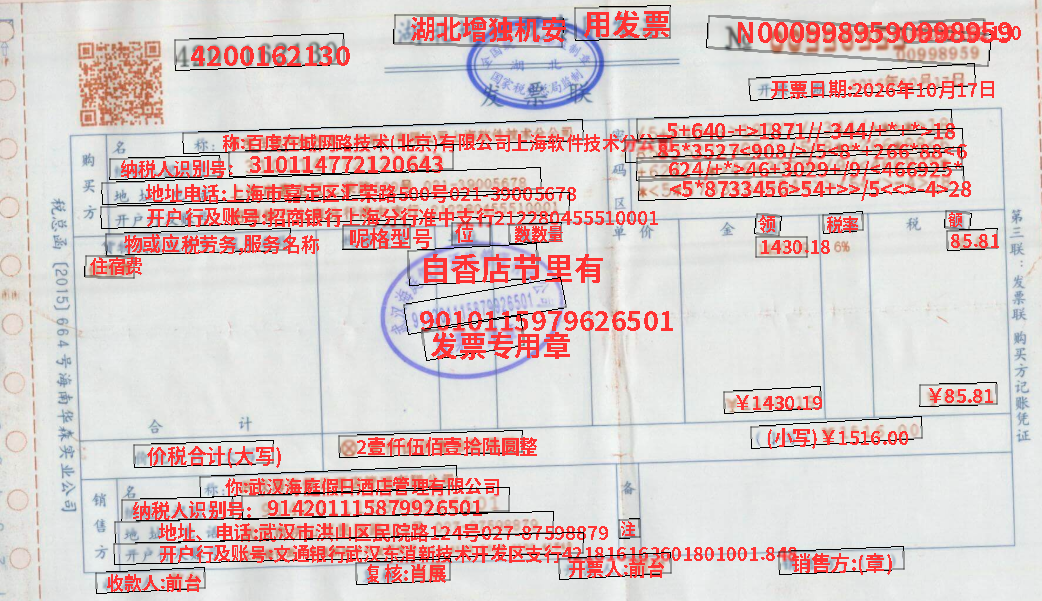

In [3]:
import time
from PIL import Image
import cv2

p = os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                 'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                 'T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.jpg')
p = os.path.join('/amax/data/xiaowentao/chineseocr/test', 'test_1.png')
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
scale=608
maxScale=2048

result, angle= model.model(img,
                        detectAngle=False,##是否进行文字方向检测
                        scale=scale,
                        maxScale=maxScale,
                        MAX_HORIZONTAL_GAP=20,##字符之间的最大间隔，用于文本行的合并
                        MIN_V_OVERLAPS=0.6,
                        MIN_SIZE_SIM=0.6,
                        TEXT_PROPOSALS_MIN_SCORE=0.1,
                        TEXT_PROPOSALS_NMS_THRESH=0.7,
                        TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                         LINE_MIN_SCORE=0.1,                                             
                        leftAdjustAlph=0,##对检测的文本行进行向左延伸
                        rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                        print_summary=False # currently broken...
                       )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
    print(line['raw res'])
plot_boxes(img,angle, result,color=(0,0,0))

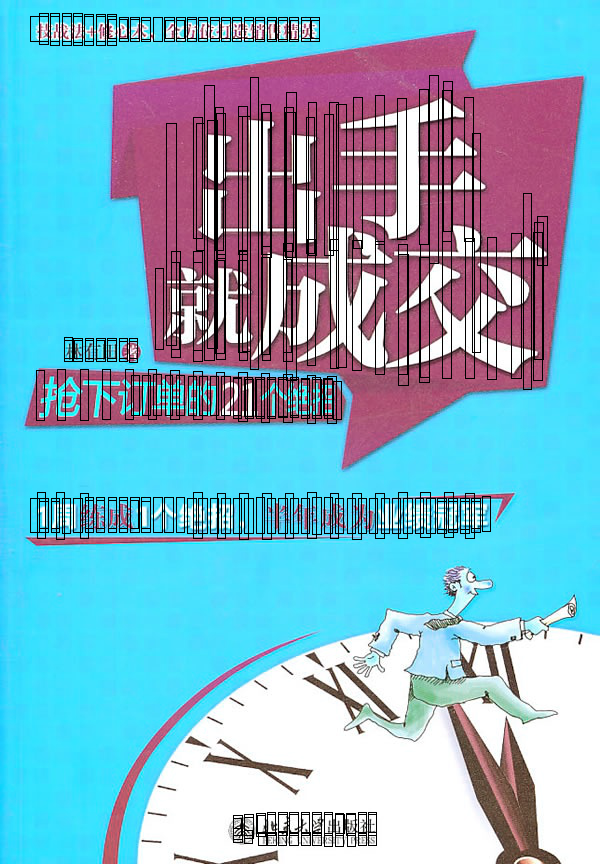

In [4]:
boxes,scores  = model.detect_box(np.array(img),608,2048)
plot_box(img,boxes)

In [5]:
"""Wrapper for various CTC decoders in SWIG."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import swig_decoders


class Scorer(swig_decoders.Scorer):
    """Wrapper for Scorer.
    :param alpha: Parameter associated with language model. Don't use
                  language model when alpha = 0.
    :type alpha: float
    :param beta: Parameter associated with word count. Don't use word
                 count when beta = 0.
    :type beta: float
    :model_path: Path to load language model.
    :type model_path: basestring
    """

    def __init__(self, alpha, beta, model_path, vocabulary):
        swig_decoders.Scorer.__init__(self, alpha, beta, model_path, vocabulary)


def ctc_greedy_decoder(probs_seq, vocabulary):
    """Wrapper for ctc best path decoder in swig.
    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :return: Decoding result string.
    :rtype: basestring
    """
    result = swig_decoders.ctc_greedy_decoder(probs_seq.tolist(), vocabulary)
    return result


def ctc_beam_search_decoder(probs_seq,
                            vocabulary,
                            beam_size,
                            cutoff_prob=1.0,
                            cutoff_top_n=40,
                            ext_scoring_func=None):
    """Wrapper for the CTC Beam Search Decoder.
    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param cutoff_prob: Cutoff probability in pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_func: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    beam_results = swig_decoders.ctc_beam_search_decoder(
        probs_seq.tolist(), vocabulary, beam_size, cutoff_prob, cutoff_top_n,
        ext_scoring_func)
    beam_results = [(res[0], res[1]) for res in beam_results]
    return beam_results


def ctc_beam_search_decoder_batch(probs_split,
                                  vocabulary,
                                  beam_size,
                                  num_processes,
                                  cutoff_prob=1.0,
                                  cutoff_top_n=40,
                                  ext_scoring_func=None):
    """Wrapper for the batched CTC beam search decoder.
    :param probs_seq: 3-D list with each element as an instance of 2-D list
                      of probabilities used by ctc_beam_search_decoder().
    :type probs_seq: 3-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param cutoff_prob: Cutoff probability in vocabulary pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_function: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    # probs_split = [probs_seq.tolist() for probs_seq in probs_split]
    probs_split = probs_split.tolist()

    batch_beam_results = swig_decoders.ctc_beam_search_decoder_batch(
        probs_split, vocabulary, beam_size, num_processes, cutoff_prob,
        cutoff_top_n, ext_scoring_func)
    batch_beam_results = [
        [(res[0], res[1]) for res in beam_results]
        for beam_results in batch_beam_results
    ]
    return batch_beam_results

In [8]:
alphabet_list = [c for c in alphabet]
scorer = Scorer(alpha=1.0, beta=0.0, model_path='./models/zh_giga.no_cna_cmn.prune01244.klm',
                vocabulary=alphabet_list)

In [9]:
import time
from PIL import Image
from torch.nn.functional import softmax 
import os

# p = './test/test_1.png'
p = os.path.join('/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                 'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                 'T10k40XfxoXXbqL6.9_074222.jpg.jpg')
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
scale=608
maxScale=2048

result,angle= model.model(img,
                        detectAngle=False,##是否进行文字方向检测
                        scale=scale,
                        maxScale=maxScale,
                        MAX_HORIZONTAL_GAP=20,##字符之间的最大间隔，用于文本行的合并
                        MIN_V_OVERLAPS=0.6,
                        MIN_SIZE_SIM=0.6,
                        TEXT_PROPOSALS_MIN_SCORE=0.1,
                        TEXT_PROPOSALS_NMS_THRESH=0.7,
                        TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                         LINE_MIN_SCORE=0.1,                                             
                        leftAdjustAlph=0,##对检测的文本行进行向左延伸
                        rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                       )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print('text:', line['text'], flush=True)
    print('raw res:', line['raw res'], flush=True)
#     print(line['raw preds'].shape, flush=True)
#     print(line['raw preds'][:, :5, :].topk(k=4, dim=2))
#     print('pred labels:', line['raw preds'].max(2)[1].view(-1))
    beam_search_results = ctc_beam_search_decoder_batch(
            probs_split=softmax(line['raw preds'], dim=2),
            vocabulary=alphabet_list,
            beam_size=50,
            num_processes=1,
            ext_scoring_func=scorer,
            cutoff_prob=1.0,
            cutoff_top_n=50)
    print('beam search results:', beam_search_results[0][:4], flush=True)
# plot_boxes(img,angle, result,color=(0,0,0))

********************************************************************** 
DEBUG: len(boxes): 281 , scores: (281,) , boxes: (281, 4)
It take:0.5449435710906982s
text: 热
raw res: 
热----
这有9数业
应人5热高
整hs国X

beam search results: [(-0.5048882961273193, ''), (1.0070059299468994, '这'), (1.42757248878479, '应'), (1.3164374828338623, '热')]
text: 050M州厚坐
raw res: 
0---------5--0--M------州-----厚-----坐--
Oh000D07.565CC1MHMSs的N州的l1mP日月一8国国生必:人
UmOgD0B116-.0-IHWH8a人m的加10WF人原15S日四尘1h
DgC999D00S97668W-m一S有h子如I数人人大具:35P业生国p

beam search results: [(2.393214464187622, '050M厚坐'), (7.066668510437012, '050厚坐'), (5.05538272857666, '05M厚坐'), (9.728889465332031, '05厚坐')]
text: 22可调喜低
raw res: 
2-----2------可-------调-----喜-----低
1合0022-0.S国F子万6一2a中中王遇188日高宫蒙1家日低街
四小220)8o088干于子5:im千口用温C22国一高复i国国人仍
3公o4)99e85中千开河中2大国年学理润金u国阳-其又有发8王何

beam search results: [(0.4937760829925537, '22子调喜低'), (0.7195465564727783, '22子调宫低'), (3.3443312644958496, '22年调喜低'), (4.357154846191406, '22调喜低')]
text: 
raw res: 
--------------------

In [68]:
!curl 'https://raw.githubusercontent.com/GitHub30/gdrive.sh/master/gdrive.sh' | env ALL_PROXY=socks5h://localhost:1080 bash -s 'https://drive.google.com/file/d/1jBPDcfe6JXwitFMWQ92UGODb58onJ2jh'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2874  100  2874    0     0   3154      0 --:--:-- --:--:-- --:--:--  3151
awk: warning: escape sequence `\?' treated as plain `?'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3272    0  3272    0     0   9088      0 --:--:-- --:--:-- --:--:--  9088
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1182      0 --:--:-- --:--:-- --:--:--  1182
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3923M    0 3923M    0     0  16.0M      0 --:--:--  0:04:04 --:--:-- 22

In [25]:
!cd '/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset/ICPR 2018 MTWI网络图片文本检测数据集'/image_9000 && ls | head -n 10 && ls ../txt_9000 | head -n 10

T10k40XfxoXXbqL6.9_074222.jpg.jpg
T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.jpg
T10qIkFk8cXXXXXXXX_!!0-item_pic.jpg.jpg
T10vNfFzJdXXXXXXXX_!!0-item_pic.jpg.jpg
T10WUiFkdfXXXXXXXX_!!0-item_pic.jpg.jpg
T10yhFXthdXXXXXXXX_!!0-item_pic.jpg.jpg
T10zjcFF0bXXa5Rw33_050206.jpg.jpg
T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.jpg
T1138BFHpbXXXXXXXX_!!0-item_pic.jpg.jpg
T11748FhpcXXXXXXXX_!!0-item_pic.jpg.jpg
ls: write error: Broken pipe
T10k40XfxoXXbqL6.9_074222.jpg.txt
T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.txt
T10qIkFk8cXXXXXXXX_!!0-item_pic.jpg.txt
T10vNfFzJdXXXXXXXX_!!0-item_pic.jpg.txt
T10WUiFkdfXXXXXXXX_!!0-item_pic.jpg.txt
T10yhFXthdXXXXXXXX_!!0-item_pic.jpg.txt
T10zjcFF0bXXa5Rw33_050206.jpg.txt
T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.txt
T1138BFHpbXXXXXXXX_!!0-item_pic.jpg.txt
T11748FhpcXXXXXXXX_!!0-item_pic.jpg.txt
ls: write error: Broken pipe


In [35]:
import os
import json
import re
cnt = 0
cnt_re = 0
total = 0
base = '/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset/ICPR 2018 MTWI网络图片文本检测数据集/txt_9000'
for f in os.listdir(base):
    with open(os.path.join(base, f)) as f:
        txt = f.readlines()
        total += len(txt)
        cnt += sum(['###' == t.split(',')[-1].strip() for t in txt])
        cnt_re += sum([re.match('^#+$', t.split(',')[-1].strip()) != None for t in txt])
# '###' 表示数据集中部分 boxes 没有可识别出来的文本（例如过于模糊），我们直接筛去它们
# 177686 个 boxes 中有 49501 个此类 boxes
print('cnt: ', cnt, 'cnt_re: ', cnt_re, 'total： ', total)

cnt:  49459 cnt_re:  49501 total：  177686


['1244.93,103.53,1224.33,793.47,1276.93,798.73,1275.93,105.53,###\n', '625.33,79.07,690.53,335.53,791.4,305.4,720.4,46.53,精品\n', '708.73,385.13,763.53,583.0,854.67,547.53,813.0,356.53,石磨\n', '237.93,222.2,577.27,1226.13,774.87,1163.8,485.2,145.87,六个土核桃\n', '118.27,336.07,268.73,813.8,293.6,803.13,150.13,328.53,石磨核桃饮品，采用古法石磨工艺，使核桃的营养成份更容易\n', '76.0,347.6,219.8,791.2,246.67,784.8,109.87,340.33,###\n', '689.87,368.07,637.93,386.0,679.33,528.07,729.27,509.87,升级版\n', '693.13,559.67,767.07,842.4,808.47,828.87,734.93,553.27,植物蛋白饮料\n', '148.53,308.47,269.47,660.33,315.67,652.4,207.73,293.4,新疆本土核桃\n', '288.67,715.8,395.33,1047.33,429.0,1037.67,339.0,703.73,好核桃更营养\n']


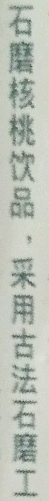

In [1]:
from apphelper.image import rotate_cut_img
from PIL import Image
import os
import cv2

# x1, y1 ~ x4, y4 为从左上角开始逆时针遍历
# 该数据集中看不清的数据用 ### 表示，而且我发现矩形框大小一般都偏小（字有一部分都漏出去了）
img = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'TB1_qqfflTH8KJjy0Fi7cERsXXa.jpg'))
with open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                       'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                       'TB1_qqfflTH8KJjy0Fi7cERsXXa.txt')) as f:
    txt = f.readlines()
    
print(txt)
# plot_rboxes(np.array(img), [[float(i) for i in t.split(',')[:-1]] for t in txt[4:5]])
rotate_cut_img(img, [float(i) for i in txt[4].split(',')[:-1]])[0]

['4.95,51.79,16.95,105.79,121.62,53.45,96.95,1.79,热卖\n', '5.29,135.45,9.29,575.12,67.29,574.12,75.29,129.45,孕妇护士裤\n', '305.29,60.79,301.29,107.45,574.29,101.45,576.29,58.79,可调节松紧\n', '476.29,130.12,464.29,249.79,528.29,254.79,529.29,137.12,粉色\n', '477.29,308.45,466.29,431.79,521.95,438.12,528.95,298.12,蓝色\n', '555.62,211.45,546.62,335.45,600.95,332.45,603.95,204.45,白色\n', '695.62,424.12,703.29,467.12,785.95,468.45,786.95,428.79,限时\n', '707.62,478.79,702.29,549.45,762.95,552.12,782.29,473.79,折\n', '797.62,553.45,794.62,519.79,756.62,517.79,766.62,547.79,扣\n']


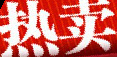

In [1]:
from apphelper.image import rotate_cut_img
from PIL import Image
import os
import cv2

# x1, y1 ~ x4, y4 为从左上角开始逆时针遍历
# 该数据集中看不清的数据用 ### 表示，而且我发现矩形框大小一般都偏小（字有一部分都漏出去了）
img = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.jpg'))
with open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                       'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                       'T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.txt')) as f:
    txt = f.readlines()
    
print(txt)
# plot_rboxes(np.array(img), [[float(i) for i in t.split(',')[:-1]] for t in txt])
rotate_cut_img(img, [float(i) for i in txt[0].split(',')[:-1]])[0]

10


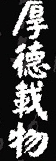

In [3]:
from apphelper.image import rotate_cut_img
from PIL import Image
import os
import cv2

# x1, y1 ~ x4, y4 为从左上角开始逆时针遍历
# 该数据集中看不清的数据用 ### 表示，而且我发现矩形框大小一般都偏小（字有一部分都漏出去了）
img = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'TB1A.0naCfD8KJjSszhXXbIJFXa_!!0-item_pic.jpg.jpg'))
with open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                       'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                       'TB1A.0naCfD8KJjSszhXXbIJFXa_!!0-item_pic.jpg.txt')) as f:
    txt = f.readlines()
    
print(txt.index('491.93,355.27,456.49,510.94,419.38,508.39,457.49,352.27,厚德载物\n'))
# plot_rboxes(np.array(img), [[float(i) for i in t.split(',')[:-1]] for t in txt[10:11]])
rotate_cut_img(img, [float(i) for i in txt[10].split(',')[:-1]])[0]

In [1]:
import h5py
import os
from time import time
from apphelper.image import rotate_cut_img
import numpy as np
import re
from PIL import Image

base = '/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset/ICPR 2018 MTWI网络图片文本检测数据集'
cnt, cnt_bad = 0, 0
print('start')
s_t = time()

# 依然有个人识别出错旋转角度的框，大概 100 个
with h5py.File("/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5", "w") as f:
    for f_img in os.listdir(os.path.join(base, 'image_9000')):
        img = Image.open(os.path.join(base, 'image_9000', f_img))
        with open(os.path.join(base, 'txt_9000', f_img[:-4] + '.txt')) as f_txt:
            txt = f_txt.readlines()
            for idx, box in enumerate(txt):
                text = box.split(',')[-1].strip()
                if not re.match('^#+$', text):
                    cnt += 1
                    box_location = [float(i) for i in box.split(',')[:-1]]
                    res = rotate_cut_img(img, box_location)
                    if abs(np.tan(res[1]['degree'] / 180 * np.pi)) > 1.732:
                        print('cnt:', cnt, ', res:', res[1], f_img, idx, box_location)
                    assert res[0].size[1] > 0 and res[0].size[0] > 0, 'src:' + f_img + '/' + str(idx) + ', txt: ' + text + ', box' + str(box_location)
                    f[str(cnt) + '/' + 'img'] = np.array(res[0])
                    f[str(cnt) + '/' + 'txt'] = text
                    f[str(cnt) + '/' + 'box'] = np.array(box_location)
                    f[str(cnt) + '/' + 'src'] = 'image_9000/' + f_img + '/' + str(idx)
                    f[str(cnt) + '/' + 'vertical'] = res[2]
                    if cnt % 2500 == 0:
                        print('sample processed:', cnt, ', time:', time() - s_t)
                else:
                    cnt_bad += 1
print('cnt:', cnt, 'cnt_bad:', cnt_bad, 'time:', time() - s_t)
!ls -alh "/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5"

start
Unexpected tanA!!!!
cnt: 381 , res: {'cx': 79.0675, 'cy': 661.375, 'w': 133.73574690410936, 'h': 76.93666226188907, 'degree': 63.338124615111354} T13JrlXcXmXXbvwaw._110954.jpg.jpg 3 [14.63, 618.75, 80.88, 732.25, 136.63, 708.75, 84.13, 585.75]
sample processed: 2500 , time: 8.940566778182983
sample processed: 5000 , time: 18.244467973709106
Unexpected tanA!!!!
cnt: 6213 , res: {'cx': 567.6925, 'cy': 173.25, 'w': 16.733937074101732, 'h': 11.437487704911462, 'degree': -61.445267479534095} TB10KxLLXXXXXaUXpXXunYpLFXX.jpg 53 [573.75, 170.09, 567.61, 179.32, 562.48, 176.91, 566.93, 166.68]
Unexpected tanA!!!!
cnt: 7301 , res: {'cx': 580.7475000000001, 'cy': 473.08500000000004, 'w': 81.59404941538332, 'h': 19.14183964513336, 'degree': -60.763554969008084} TB11gROLXXXXXXbXpXXunYpLFXX.jpg 7 [595.33, 434.0, 606.0, 441.0, 565.33, 511.67, 556.33, 505.67]
Unexpected tanA!!!!
cnt: 7458 , res: {'cx': 360.76750000000004, 'cy': 354.5375, 'w': 20.187509133124877, 'h': 11.855097005086009, 'degree'

sample processed: 47500 , time: 192.32027578353882
sample processed: 50000 , time: 202.71171140670776
Unexpected tanA!!!!
cnt: 51131 , res: {'cx': 293.1675, 'cy': 514.8074999999999, 'w': 49.64874419358455, 'h': 37.5299880095904, 'degree': -65.12623246577843} TB1j2XJLXXXXXcsXpXXunYpLFXX.jpg 11 [289.67, 494.89, 275.33, 527.89, 293.0, 540.56, 314.67, 495.89]
sample processed: 52500 , time: 212.36034607887268
Unexpected tanA!!!!
cnt: 54607 , res: {'cx': 558.0799999999999, 'cy': 272.9525, 'w': 76.61890758814047, 'h': 37.47892507796894, 'degree': 60.26203269763869} TB1kBOObfBNTKJjSszeXXcu2VXa_!!0-item_pic.jpg.jpg 18 [531.71, 246.33, 563.52, 305.67, 588.33, 302.71, 548.76, 237.1]
Unexpected tanA!!!!
cnt: 54961 , res: {'cx': 439.46, 'cy': 183.19500000000002, 'w': 34.884982442305954, 'h': 19.39500000000004, 'degree': -72.67662085277217} TB1kFNCLXXXXXbiXFXXunYpLFXX.jpg 8 [436.15, 173.08, 433.69, 192.62, 438.92, 194.0, 449.08, 173.08]
sample processed: 55000 , time: 222.3603756427765
Unexpected t

Unexpected tanA!!!!
cnt: 87496 , res: {'cx': 719.5, 'cy': 253.75, 'w': 56.43580423808976, 'h': 28.65745976181418, 'degree': -66.03751102542182} TB1w.hmcN6I8KJjSszfXXaZVXXa_!!0-item_pic.jpg.jpg 2 [715.5, 285.0, 701.5, 272.0, 729.5, 223.0, 731.5, 235.0]
sample processed: 87500 , time: 355.6318156719208
Unexpected tanA!!!!
cnt: 88918 , res: {'cx': 282.835, 'cy': 322.09499999999997, 'w': 15.482804978426884, 'h': 9.447487761304615, 'degree': -60.98585493349922} TB1wHc0n9fD8KJjSszhXXbIJFXa_!!0-item_pic.jpg.jpg 20 [278.44, 324.96, 282.21, 316.81, 288.13, 318.96, 282.56, 327.65]
sample processed: 90000 , time: 365.1290202140808
Unexpected tanA!!!!
cnt: 91222 , res: {'cx': 641.83, 'cy': 277.05, 'w': 39.11521443121592, 'h': 23.717082451262854, 'degree': 62.40270413135629} TB1xB33oSfD8KJjSszhXXbIJFXa_!!2-item_pic.png.jpg 6 [628.58, 268.55, 642.58, 290.55, 652.58, 285.55, 643.58, 263.55]
Unexpected tanA!!!!
cnt: 92089 , res: {'cx': 520.985, 'cy': 341.4825, 'w': 26.411665036494696, 'h': 12.90007848

sample processed: 120000 , time: 494.0773720741272
sample processed: 122500 , time: 504.7206172943115
Unexpected tanA!!!!
cnt: 123030 , res: {'cx': 851.1975, 'cy': 537.77, 'w': 56.95384644604792, 'h': 40.30020161239895, 'degree': -64.61864942643389} TB2Qle1dsbI8KJjy1zdXXbe1VXa_!!546185834.jpg.jpg 17 [836.71, 547.82, 849.91, 560.97, 870.11, 528.82, 848.06, 513.47]
Unexpected tanA!!!!
cnt: 123035 , res: {'cx': 545.0225, 'cy': 337.895, 'w': 96.02162516850052, 'h': 54.26238337928032, 'degree': -62.42573237147374} TB2Qle1dsbI8KJjy1zdXXbe1VXa_!!546185834.jpg.jpg 22 [506.36, 372.97, 539.61, 387.22, 580.26, 301.87, 553.86, 289.52]
Unexpected tanA!!!!
cnt: 123143 , res: {'cx': 81.3175, 'cy': 483.0675, 'w': 84.75331556936283, 'h': 28.212156954050897, 'degree': 61.89435791992662} TB2Qo8bwSFmpuFjSZFrXXayOXXa_!!3284731990.jpg.jpg 40 [103.09, 510.09, 72.09, 446.36, 53.91, 451.18, 96.18, 524.64]
Unexpected tanA!!!!
cnt: 124111 , res: {'cx': 409.9675, 'cy': 227.0925, 'w': 33.92935012640237, 'h': 17.32

128185
精品
input size: torch.Size([1, 1, 81, 32])
debug conv feature size in forward (b, c, h, w):  torch.Size([1, 512, 21, 1])
[{'img': <PIL.Image.Image image mode=L size=106x269 at 0x7FDA9C0DFC90>, 'text': '', 'raw res': '\n---------------------\n不尔子子子子子子子yyyyyyyyyyyy\n子小y中y中y中y子子子l子子子子子h子子\n师师不小了市了人f人人hh人hhhhg5一\n', 'raw preds': tensor([[[-119.7250, -145.4026, -156.1505,  ..., -161.8901, -170.8026,
          -168.7359],
         [-111.9638, -137.7396, -139.9060,  ..., -147.3346, -154.5418,
          -155.3337],
         [-106.0917, -141.2961, -161.5968,  ..., -179.5540, -189.1496,
          -193.9927],
         ...,
         [-134.6588, -179.2007, -191.6339,  ..., -209.5487, -219.0738,
          -224.4959],
         [-132.8489, -165.4555, -168.7248,  ..., -174.9645, -183.5264,
          -192.6794],
         [-120.0531, -164.0331, -169.1920,  ..., -178.5481, -185.8283,
          -196.3251]]], device='cuda:0', grad_fn=<TransposeBackward0>)}]


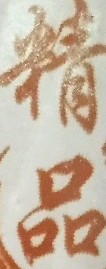

In [27]:
import h5py
from PIL import Image
import os

with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    print(len(f['.']))
    img = Image.fromarray(f['101534/img'][...]).convert('RGB')
    print(f['101534/txt'][...])
img_all = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'TB1_qqfflTH8KJjy0Fi7cERsXXa.jpg'))
txt = open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                              'TB1_qqfflTH8KJjy0Fi7cERsXXa.txt')).readlines()
# print(txt)
# plot_rboxes(np.array(img_all), [[float(i) for i in t.split(',')[:-1]] for t in txt])


from crnn.network_torch import CRNN
boxes = [{'img': img.convert('L')}]
from crnn.keys import alphabetChinese as alphabet
nclass = len(alphabet)+1
from config import ocrModelTorchLstm as ocrModel
GPU = True
LSTMFLAG = True
# DCMMC: 结果说明简单更改一下代码确实是可以运行，但是该模型并没有训练竖排文字
crnn = CRNN(32, 1, nclass, 256, leakyRelu=False,lstmFlag=LSTMFLAG,GPU=GPU,alphabet=alphabet, vertical_text=True)
crnn.load_weights(ocrModel)
boxes = crnn.predict_job(boxes)
print(boxes)
img

128185
石磨核桃饮品，采用古法石磨工艺，使核桃的营养成份更容易
input size: torch.Size([1, 1, 327, 32])
debug conv feature size in forward (b, c, h, w):  torch.Size([1, 512, 82, 1])
[{'img': <PIL.Image.Image image mode=L size=49x501 at 0x7FDA94254590>, 'text': '风具间育官育育7育育育育fTygT', 'raw res': '\n---------------------------风---------具---间-育-官-育---育7育---育-育育育-育育育--fffTyggggT----\n3子hhh子行子风hh子人人人人风人风人风风风人人人风-风风人育风风风风风育风具风育7间7育7宜育777育肯7育育行行肯肯肯子货具官gf-育TyTTbbbbbyoy\n77n子yy子h子子y人尔风风风人风人风人人行风风风人人人人风风人人人人人片具育7-y赏y具人赏7行风官风赏育气人人人具赏具育行-肯具ygyy-pb5TT-hhy小\n5新yy子h人y行f子7风尔bb行r行入行b人行行行具具yb育具行日日日7风育y具片h负风片风-风y行气具宜具行7y子官宜赏具官官具f777gfgpppopoTh的\n', 'raw preds': tensor([[[ -77.8972, -129.3982, -148.6547,  ..., -160.4297, -167.0170,
          -163.4781],
         [-134.3093, -171.8694, -179.5520,  ..., -197.3041, -193.3246,
          -182.9818],
         [-112.7224, -155.0433, -164.3697,  ..., -176.6107, -183.4138,
          -175.2011],
         ...,
         [-130.2011, -169.8216, -169.6475,  ..., -177.2868, -190.6010,
          -193.24

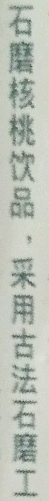

In [29]:
import h5py
from PIL import Image
import os

with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    print(len(f['.']))
    img = Image.fromarray(f['101537/img'][...]).convert('RGB')
    print(f['101537/txt'][...])
img_all = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'TB1_qqfflTH8KJjy0Fi7cERsXXa.jpg'))
txt = open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                              'TB1_qqfflTH8KJjy0Fi7cERsXXa.txt')).readlines()
# print(txt)
# plot_rboxes(np.array(img_all), [[float(i) for i in t.split(',')[:-1]] for t in txt])


from crnn.network_torch import CRNN
boxes = [{'img': img.convert('L')}]
from crnn.keys import alphabetChinese as alphabet
nclass = len(alphabet)+1
from config import ocrModelTorchLstm as ocrModel
GPU = True
LSTMFLAG = True
crnn = CRNN(32, 1, nclass, 256, leakyRelu=False,lstmFlag=LSTMFLAG,GPU=GPU,alphabet=alphabet, vertical_text=True)
crnn.load_weights(ocrModel)
boxes = crnn.predict_job(boxes)
print(boxes)
img

In [28]:
import h5py

with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    for sample in f:
        if 'TB1_qqfflTH8KJjy0Fi7cERsXXa' in str(f[sample]['src'][...]) and \
                '石磨核桃饮品，采用古法石磨工艺，使核桃的营养成份更容易' in str(f[sample]['txt'][...]):
            print('found!', bool(f[sample]['vertical'][...]), sample)
            break

found! True 101537


In [31]:
import h5py

cnt_vertical = 0
cnt_horizontal = 0
with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    for sample in f:
        if bool(f[sample]['vertical'][...]):
            cnt_vertical += 1
        else:
            cnt_horizontal += 1
# 结果显示大部分为水平文字（121452），少部分为竖排文字（6733）
print('vertical text:', cnt_vertical, ', horizontal text:', cnt_horizontal)

vertical text: 6733 , horizontal text: 121452


In [35]:
from Levenshtein import distance as levenshtein_distance

# 编辑距离是 symmetric evaluation metric
print(levenshtein_distance('aa', 'bcde'), levenshtein_distance('bcde', 'aa'))

4 4


In [1]:
# 全部导入内存，批处理，然后计算编辑距离并归一化
# 1. best path greedy 2. CTC beam search with n-gram LM (grid search for hyperparameters)
# 3. replace n-gram LM in CTC beam search with XLNet
# 4. 复现 Transormfer-based spell corrector

import h5py
from PIL import Image
import os
from time import time
# 选用归一化后的编辑距离作为 evaluation metric
from Levenshtein import distance as levenshtein_distance
# model
from crnn.network_torch import CRNN
from crnn.keys import alphabetChinese as alphabet
from config import ocrModelTorchLstm as ocrModel

GPUID = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)
s_t = time()
nclass = len(alphabet) + 1
GPU = True
LSTMFLAG = True
crnn = CRNN(32, 1, nclass, 256, leakyRelu=False, lstmFlag=LSTMFLAG, GPU=GPU, alphabet=alphabet,
            vertical_text=False)
crnn.load_weights(ocrModel)
print('Load model done in {:.4f}s.'.format(time() - s_t))
s_t = time()

def levenshtein_distance_norm(str1, str2):
    '''
    归一化的编辑距离, 越小越好
    @return [0, 1]
    '''
    max_len = max(len(str1), len(str2), 1)
    return levenshtein_distance(str1, str2) / max_len


# 因为数据规模不大，所以直接全部加载到内存
dataset_boxes = []
with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    print('Loading dataset into memory.')
    for img in f:
        # 暂时只考虑水平文本行
        if not bool(f[img]['vertical'][...]):
#             if len(dataset_boxes) >= 1 * 256 * 10:
#                 break
            dataset_boxes.append({
                # 灰度图
                'img': Image.fromarray(f[img]['img'][...]).convert('RGB').convert('L'),
                # 标签
                'true_text': str(f[img]['txt'][...])
            })
print('Dataset loaded, #sample={}, took {:.4f}s.'.format(len(dataset_boxes), time() - s_t))

# 发现在大 batch 的时候效果特别差（batch_size=256 的时候，0.98 的loss），随着 batch 逐渐减小，效果越来越好。。
# 因为每个样本大小不一样，在缩放到统一高度 （32）的时候，宽度依然不一样，每一个 batch 中所有样本会 zero-padding
# 到相同长度（样本中的最大长度），然而可能是训练的时候没有很好的构造这样的数据集，导致结果相当差
# batch=1 导致显卡利用率太低了。
# 结果表明 12w 样本的推导时间大概为 18min，最终结果在 0.33 左右的 loss，也就是说，对于 10 个字的文本的识别，
# 模型预测的文本大概需要三次编辑就可以达到正确的文本。
# 该结果在阿里天池比赛 ICPR MTWI 2018 CHALLENGE 1 中，应该能达到 24 名左右的名次
# inference
boxes, losses, loss_total = crnn.predict_batch(dataset_boxes, batch_size=1, evaluation_per_batch=256 * 50,
                                               evaluation_metric=levenshtein_distance_norm)

Load model done in 4.3363s.
Loading dataset into memory.
Dataset loaded, #sample=121452, took 170.0791s.
#Batch: 121452 with batch_size=1
overall loss in 12800 batches with batch_size=1 is 0.305235, took 112.4648s.
overall loss in 25600 batches with batch_size=1 is 0.316711, took 223.6706s.
overall loss in 38400 batches with batch_size=1 is 0.318154, took 333.2583s.
overall loss in 51200 batches with batch_size=1 is 0.322303, took 448.7014s.
overall loss in 64000 batches with batch_size=1 is 0.324852, took 560.9327s.
overall loss in 76800 batches with batch_size=1 is 0.326386, took 671.4531s.
overall loss in 89600 batches with batch_size=1 is 0.329610, took 779.7388s.
overall loss in 102400 batches with batch_size=1 is 0.329661, took 890.0662s.
overall loss in 115200 batches with batch_size=1 is 0.329624, took 998.9281s.
All done after 1053.7140s, the overall loss is: 0.329643


In [1]:
# 全部导入内存，批处理，然后计算编辑距离并归一化
# 1. best path greedy 2. CTC beam search with n-gram LM (grid search for hyperparameters)
# 3. replace n-gram LM in CTC beam search with XLNet
# 4. 复现 Transormfer-based spell corrector

import h5py
from PIL import Image
import os
from time import time
# 选用归一化后的编辑距离作为 evaluation metric
from Levenshtein import distance as levenshtein_distance
# model
from crnn.network_torch import CRNN
from crnn.keys import alphabetChinese as alphabet
from config import ocrModelTorchLstm as ocrModel
# decoders 取自 baidu 的 [DeepSpeech](https://github.com/PaddlePaddle/DeepSpeech)
import swig_decoders
import random
from torch.nn.functional import softmax
import numpy as np
# matplotlib
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


class Scorer(swig_decoders.Scorer):
    def __init__(self, alpha, beta, model_path, vocabulary):
        swig_decoders.Scorer.__init__(self, alpha, beta, model_path, vocabulary)


def ctc_beam_search_decoder_batch_pred(probs_split,
                                      vocabulary,
                                      beam_size,
                                      num_processes,
                                      cutoff_prob=1.0,
                                      cutoff_top_n=40,
                                      ext_scoring_func=None):
    probs_split = [probs.tolist() for probs in probs_split]

    batch_beam_results = swig_decoders.ctc_beam_search_decoder_batch(
        probs_split, vocabulary, beam_size, num_processes, cutoff_prob,
        cutoff_top_n, ext_scoring_func)
    return [result[0][1] for result in batch_beam_results]


def levenshtein_distance_norm(str1, str2):
    '''
    归一化的编辑距离, 越小越好
    @return [0, 1]
    '''
    max_len = max(len(str1), len(str2), 1)
    return levenshtein_distance(str1, str2) / max_len


GPUID = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)
s_t = time()
nclass = len(alphabet) + 1
GPU = True
LSTMFLAG = True
crnn = CRNN(32, 1, nclass, 256, leakyRelu=False, lstmFlag=LSTMFLAG, GPU=GPU, alphabet=alphabet,
            vertical_text=False)
crnn.load_weights(ocrModel)
print('Load model done in {:.4f}s.'.format(time() - s_t))

# Tuning hyperparameters \alpha and \beta of Scorer by grid search
alpha_start, alpha_end, num_alpha = 0.0, 3.0, 12
beta_start, beta_end, num_beta = 0.0, 1.0, 5
alphabet_list = [c for c in alphabet]
# create grid for search
cand_alphas = np.linspace(alpha_start, alpha_end, num_alpha)
cand_betas = np.linspace(beta_start, beta_end, num_beta)
params_grid = [(alpha, beta) for alpha in cand_alphas
               for beta in cand_betas]
# 应为 CTC beam search 实在是有点慢，所以最好采用多线程，这里分配 20 核
ctc_buffer_size = 20
print('{} trials for grid search created.'.format(len(params_grid)))
s_t = time()


# 因为数据规模不大，所以直接全部加载到内存
dataset_boxes_all = []
with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    print('Loading dataset into memory.')
    for img in f:
        # 暂时只考虑水平文本行
        if not bool(f[img]['vertical'][...]):
            if len(dataset_boxes_all) >= 1 * 256 * 10:
                break
            dataset_boxes_all.append({
                # 灰度图
                'img': Image.fromarray(f[img]['img'][...]).convert('RGB').convert('L'),
                # 标签
                'true_text': str(f[img]['txt'][...])
            })
print('Dataset loaded, #sample={}, took {:.4f}s.'.format(len(dataset_boxes_all), time() - s_t))
# random sample 1/4 from dataset
dataset_boxes = random.sample(dataset_boxes_all, len(dataset_boxes_all) // 24)
del dataset_boxes_all
print('Randomly sample 1/24 from dataset: {} samples.'.format(len(dataset_boxes)))

# inference
grid_res = []
scorer = None
for idx, (alpha, beta) in enumerate(params_grid):
    # CTC beam search with language model Scorer
    scorer = Scorer(alpha=alpha, beta=beta, model_path=os.path.join('/data/xiaowentao/chineseocr',
                                                                 'models/zh_giga.no_cna_cmn.prune01244.klm'),
                    vocabulary=alphabet_list)
    print('scorer done.')
    # 默认的 beam_size=500 特别慢
    ctc_beam_lm_decoder = lambda raw_preds: ctc_beam_search_decoder_batch_pred(
            probs_split=[softmax(raw_pred, dim=1) for raw_pred in raw_preds],
            vocabulary=alphabet_list,
            beam_size=10,
            num_processes=ctc_buffer_size,
            ext_scoring_func=scorer,
            cutoff_prob=1.0,
            cutoff_top_n=50)
    boxes, losses, loss_total = crnn.predict_batch(dataset_boxes, batch_size=1, evaluation_per_batch=50,
                                                   evaluation_metric=levenshtein_distance_norm,
                                                   ctc_beam_lm_decoder=ctc_beam_lm_decoder,
                                                   ctc_buffer_size=ctc_buffer_size)
    grid_res.append(loss_total)
    print('-' * 60, '\nTrial {} done, loss for alpha={} and beta={} is: {:.6f}'.format(idx,
                                                                                       alpha,
                                                                                       beta,
                                                                                       loss_total))
    
# plot the results
best_res_idx = np.argmax(grid_res)
print('All done, the best result for grid research is: {} when alpha={} and beta={}.'.format(
    params_grid[best_res_idx], *grid_res[best_res_idx]))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface([i[0] for i in params_grid], [i[1] for i in params_grid],
                       grid_res, cmap=cm.coolwarm, alpha=0.7,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.1, 1.0)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.04f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Load model done in 4.3638s.
60 trials for grid search created.
Loading dataset into memory.
Dataset loaded, #sample=2560, took 3.7124s.
Randomly sample 1/24 from dataset: 106 samples.
scorer done.
#Batch: 106 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.209928, took 2.3654s.
overall loss in 100 batches with batch_size=1 is 0.299762, took 5.2652s.
All done after 5.3058s, the overall loss is: 0.282794
------------------------------------------------------------ 
Trial 0 done, loss for alpha=0.0 and beta=0.0 is: 0.282794
scorer done.
#Batch: 106 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.208967, took 1.7464s.
overall loss in 100 batches with batch_size=1 is 0.299281, took 4.8246s.
All done after 4.8659s, the overall loss is: 0.282341
------------------------------------------------------------ 
Trial 1 done, loss for alpha=0.0 and beta=0.25 is: 0.282341
scorer done.
#Batch: 106 with batch_size=1


KeyboardInterrupt: 

In [2]:
import subprocess
import sys
import numpy as np

alpha_start, alpha_end, num_alpha = 0.0, 3.0, 12
beta_start, beta_end, num_beta = 0.0, 1.0, 5
cand_alphas = np.linspace(alpha_start, alpha_end, num_alpha)
cand_betas = np.linspace(beta_start, beta_end, num_beta)
params_grid = [(alpha, beta) for alpha in cand_alphas
               for beta in cand_betas]
seed = 1234

with open('ctc_beam_grid_search.log', 'ab') as f:
    for idx, (alpha, beta) in enumerate(params_grid):
        curr = 'idx: {}, alpha={:.4f}, beta={:.4f}, seed={}\n\n'.format(
            idx, alpha, beta, seed).encode('utf-8')
        f.write(curr)
        sys.stdout.write(curr)
        process = subprocess.Popen('python -u ./test_ctc_beam.py {:.4f} {:.4f} {}'.format(
            alpha, beta, seed), shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        for line in iter(lambda: process.stdout.readline(), b''):
            sys.stdout.write(line)
            sys.stdout.flush()
            f.write(line)

idx: 0, alpha=0.0000, beta=0.0000, seed=1234

Load model done in 4.3139s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 53.4491s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.335190, took 2.3772s.
overall loss in 100 batches with batch_size=1 is 0.397077, took 5.0763s.
overall loss in 150 batches with batch_size=1 is 0.340051, took 7.2438s.
overall loss in 200 batches with batch_size=1 is 0.338507, took 10.3782s.
overall loss in 250 batches with batch_size=1 is 0.327001, took 12.5680s.
overall loss in 300 batches with batch_size=1 is 0.321945, took 15.6626s.
overall loss in 350 batches with batch_size=1 is 0.310633, took 17.6788s.
overall loss in 400 batches with batch_size=1 is 0.348164, took 20.3624s.
overall loss in 450 batches with batch_size=1 is 0.343228, took 22.6246s.
overall loss in 500 batches with batch_size=1 is 0.343679, took 25.2720s.
overall loss in 550 bat

All done after 257.1239s, the overall loss is: 0.311636
------------------------------------------------------------ 
loss for alpha=0.0 and beta=0.0 is: 0.311636
idx: 1, alpha=0.0000, beta=0.2500, seed=1234

Load model done in 3.8811s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 50.1948s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.335190, took 2.1366s.
overall loss in 100 batches with batch_size=1 is 0.396895, took 4.3562s.
overall loss in 150 batches with batch_size=1 is 0.339930, took 6.4174s.
overall loss in 200 batches with batch_size=1 is 0.337916, took 9.0553s.
overall loss in 250 batches with batch_size=1 is 0.327061, took 10.9307s.
overall loss in 300 batches with batch_size=1 is 0.321800, took 13.5523s.
overall loss in 350 batches with batch_size=1 is 0.310508, took 15.2943s.
overall loss in 400 batches with batch_size=1 is 0.348055, took 17.3866s.
overall l

overall loss in 5250 batches with batch_size=1 is 0.311033, took 228.9212s.
overall loss in 5300 batches with batch_size=1 is 0.311333, took 231.7082s.
All done after 233.3632s, the overall loss is: 0.311277
------------------------------------------------------------ 
loss for alpha=0.0 and beta=0.25 is: 0.311277
idx: 2, alpha=0.0000, beta=0.5000, seed=1234

Load model done in 3.7699s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 48.8741s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.335190, took 1.9677s.
overall loss in 100 batches with batch_size=1 is 0.390974, took 4.2757s.
overall loss in 150 batches with batch_size=1 is 0.335110, took 6.2848s.
overall loss in 200 batches with batch_size=1 is 0.334301, took 9.0456s.
overall loss in 250 batches with batch_size=1 is 0.323369, took 10.7847s.
overall loss in 300 batches with batch_size=1 is 0.318390, took 13.1456s.
over

overall loss in 5150 batches with batch_size=1 is 0.310779, took 228.7615s.
overall loss in 5200 batches with batch_size=1 is 0.310418, took 233.3252s.
overall loss in 5250 batches with batch_size=1 is 0.310600, took 234.9848s.
overall loss in 5300 batches with batch_size=1 is 0.310904, took 238.0265s.
All done after 239.5400s, the overall loss is: 0.310836
------------------------------------------------------------ 
loss for alpha=0.0 and beta=0.5 is: 0.310836
idx: 3, alpha=0.0000, beta=0.7500, seed=1234

Load model done in 3.8382s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 46.4846s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.335857, took 1.7966s.
overall loss in 100 batches with batch_size=1 is 0.387974, took 3.9638s.
overall loss in 150 batches with batch_size=1 is 0.333776, took 6.1879s.
overall loss in 200 batches with batch_size=1 is 0.332587, took 8.9292s.
o

overall loss in 5050 batches with batch_size=1 is 0.311567, took 228.3847s.
overall loss in 5100 batches with batch_size=1 is 0.310924, took 231.3955s.
overall loss in 5150 batches with batch_size=1 is 0.309937, took 233.5033s.
overall loss in 5200 batches with batch_size=1 is 0.309584, took 238.1896s.
overall loss in 5250 batches with batch_size=1 is 0.309774, took 239.9106s.
overall loss in 5300 batches with batch_size=1 is 0.310091, took 243.0073s.
All done after 244.5540s, the overall loss is: 0.310061
------------------------------------------------------------ 
loss for alpha=0.0 and beta=0.75 is: 0.310061
idx: 4, alpha=0.0000, beta=1.0000, seed=1234

Load model done in 3.8664s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 47.4301s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.336333, took 2.0624s.
overall loss in 100 batches with batch_size=1 is 0.389004, took 4.4

overall loss in 4950 batches with batch_size=1 is 0.312532, took 227.7560s.
overall loss in 5000 batches with batch_size=1 is 0.313336, took 230.4429s.
overall loss in 5050 batches with batch_size=1 is 0.311405, took 232.6490s.
overall loss in 5100 batches with batch_size=1 is 0.310763, took 234.9802s.
overall loss in 5150 batches with batch_size=1 is 0.309772, took 237.3672s.
overall loss in 5200 batches with batch_size=1 is 0.309421, took 241.9302s.
overall loss in 5250 batches with batch_size=1 is 0.309675, took 243.9549s.
overall loss in 5300 batches with batch_size=1 is 0.309993, took 247.1085s.
All done after 248.8566s, the overall loss is: 0.309971
------------------------------------------------------------ 
loss for alpha=0.0 and beta=1.0 is: 0.309971
idx: 5, alpha=0.2727, beta=0.0000, seed=1234

Load model done in 3.9179s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 48.0686s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with b

overall loss in 4850 batches with batch_size=1 is 0.340453, took 228.5451s.
overall loss in 4900 batches with batch_size=1 is 0.342303, took 231.7084s.
overall loss in 4950 batches with batch_size=1 is 0.340588, took 234.4324s.
overall loss in 5000 batches with batch_size=1 is 0.341626, took 237.0296s.
overall loss in 5050 batches with batch_size=1 is 0.339562, took 239.8792s.
overall loss in 5100 batches with batch_size=1 is 0.339185, took 242.8951s.
overall loss in 5150 batches with batch_size=1 is 0.337994, took 245.2393s.
overall loss in 5200 batches with batch_size=1 is 0.337361, took 249.9171s.
overall loss in 5250 batches with batch_size=1 is 0.337415, took 251.8136s.
overall loss in 5300 batches with batch_size=1 is 0.337613, took 255.5344s.
All done after 257.2727s, the overall loss is: 0.337603
------------------------------------------------------------ 
loss for alpha=0.2727 and beta=0.0 is: 0.337603
idx: 6, alpha=0.2727, beta=0.2500, seed=1234

Load model done in 4.2345s.


overall loss in 4750 batches with batch_size=1 is 0.341073, took 260.1918s.
overall loss in 4800 batches with batch_size=1 is 0.340654, took 263.9026s.
overall loss in 4850 batches with batch_size=1 is 0.339043, took 266.1418s.
overall loss in 4900 batches with batch_size=1 is 0.340789, took 269.3509s.
overall loss in 4950 batches with batch_size=1 is 0.339089, took 272.1706s.
overall loss in 5000 batches with batch_size=1 is 0.340142, took 275.8445s.
overall loss in 5050 batches with batch_size=1 is 0.338093, took 278.5911s.
overall loss in 5100 batches with batch_size=1 is 0.337730, took 281.9322s.
overall loss in 5150 batches with batch_size=1 is 0.336554, took 284.6506s.
overall loss in 5200 batches with batch_size=1 is 0.335935, took 290.1356s.
overall loss in 5250 batches with batch_size=1 is 0.336002, took 292.4953s.
overall loss in 5300 batches with batch_size=1 is 0.336214, took 296.3406s.
All done after 298.1614s, the overall loss is: 0.336121
--------------------------------

overall loss in 4650 batches with batch_size=1 is 0.341122, took 269.2216s.
overall loss in 4700 batches with batch_size=1 is 0.341885, took 273.3300s.
overall loss in 4750 batches with batch_size=1 is 0.339422, took 275.6465s.
overall loss in 4800 batches with batch_size=1 is 0.339021, took 279.8299s.
overall loss in 4850 batches with batch_size=1 is 0.337427, took 282.1693s.
overall loss in 4900 batches with batch_size=1 is 0.339189, took 285.4895s.
overall loss in 4950 batches with batch_size=1 is 0.337505, took 288.3356s.
overall loss in 5000 batches with batch_size=1 is 0.338574, took 291.3990s.
overall loss in 5050 batches with batch_size=1 is 0.336541, took 294.5068s.
overall loss in 5100 batches with batch_size=1 is 0.336193, took 298.2124s.
overall loss in 5150 batches with batch_size=1 is 0.335038, took 300.7010s.
overall loss in 5200 batches with batch_size=1 is 0.334434, took 306.3148s.
overall loss in 5250 batches with batch_size=1 is 0.334502, took 308.9212s.
overall loss

overall loss in 4550 batches with batch_size=1 is 0.339799, took 277.4308s.
overall loss in 4600 batches with batch_size=1 is 0.339922, took 280.2259s.
overall loss in 4650 batches with batch_size=1 is 0.339894, took 282.6602s.
overall loss in 4700 batches with batch_size=1 is 0.340669, took 287.2782s.
overall loss in 4750 batches with batch_size=1 is 0.338220, took 289.4288s.
overall loss in 4800 batches with batch_size=1 is 0.337796, took 293.4047s.
overall loss in 4850 batches with batch_size=1 is 0.336283, took 295.2938s.
overall loss in 4900 batches with batch_size=1 is 0.338042, took 298.7675s.
overall loss in 4950 batches with batch_size=1 is 0.336369, took 301.3638s.
overall loss in 5000 batches with batch_size=1 is 0.337200, took 304.8944s.
overall loss in 5050 batches with batch_size=1 is 0.335180, took 308.1686s.
overall loss in 5100 batches with batch_size=1 is 0.334649, took 311.5084s.
overall loss in 5150 batches with batch_size=1 is 0.333511, took 314.1047s.
overall loss

overall loss in 4450 batches with batch_size=1 is 0.338711, took 262.7996s.
overall loss in 4500 batches with batch_size=1 is 0.339672, took 265.6143s.
overall loss in 4550 batches with batch_size=1 is 0.337399, took 267.6488s.
overall loss in 4600 batches with batch_size=1 is 0.337563, took 271.1650s.
overall loss in 4650 batches with batch_size=1 is 0.337561, took 273.6684s.
overall loss in 4700 batches with batch_size=1 is 0.338361, took 279.1345s.
overall loss in 4750 batches with batch_size=1 is 0.335936, took 282.0109s.
overall loss in 4800 batches with batch_size=1 is 0.335536, took 285.9557s.
overall loss in 4850 batches with batch_size=1 is 0.334046, took 289.0088s.
overall loss in 4900 batches with batch_size=1 is 0.335805, took 293.1036s.
overall loss in 4950 batches with batch_size=1 is 0.333913, took 296.6025s.
overall loss in 5000 batches with batch_size=1 is 0.334688, took 299.5845s.
overall loss in 5050 batches with batch_size=1 is 0.332653, took 302.7429s.
overall loss

overall loss in 4350 batches with batch_size=1 is 0.364793, took 245.6922s.
overall loss in 4400 batches with batch_size=1 is 0.364902, took 248.5554s.
overall loss in 4450 batches with batch_size=1 is 0.363958, took 251.5253s.
overall loss in 4500 batches with batch_size=1 is 0.364732, took 253.7592s.
overall loss in 4550 batches with batch_size=1 is 0.362386, took 255.3252s.
overall loss in 4600 batches with batch_size=1 is 0.362367, took 258.3936s.
overall loss in 4650 batches with batch_size=1 is 0.362372, took 260.5624s.
overall loss in 4700 batches with batch_size=1 is 0.363288, took 264.4578s.
overall loss in 4750 batches with batch_size=1 is 0.360634, took 266.6465s.
overall loss in 4800 batches with batch_size=1 is 0.360151, took 269.9220s.
overall loss in 4850 batches with batch_size=1 is 0.358304, took 271.7987s.
overall loss in 4900 batches with batch_size=1 is 0.360121, took 275.1994s.
overall loss in 4950 batches with batch_size=1 is 0.358248, took 277.9913s.
overall loss

overall loss in 4250 batches with batch_size=1 is 0.359597, took 236.0268s.
overall loss in 4300 batches with batch_size=1 is 0.361267, took 238.4946s.
overall loss in 4350 batches with batch_size=1 is 0.361431, took 240.9749s.
overall loss in 4400 batches with batch_size=1 is 0.361579, took 243.7892s.
overall loss in 4450 batches with batch_size=1 is 0.360673, took 246.4419s.
overall loss in 4500 batches with batch_size=1 is 0.361516, took 248.7724s.
overall loss in 4550 batches with batch_size=1 is 0.359190, took 250.6620s.
overall loss in 4600 batches with batch_size=1 is 0.359170, took 253.6950s.
overall loss in 4650 batches with batch_size=1 is 0.359209, took 255.8310s.
overall loss in 4700 batches with batch_size=1 is 0.360159, took 259.9113s.
overall loss in 4750 batches with batch_size=1 is 0.357539, took 262.2866s.
overall loss in 4800 batches with batch_size=1 is 0.356983, took 265.8246s.
overall loss in 4850 batches with batch_size=1 is 0.355118, took 267.9030s.
overall loss

overall loss in 4150 batches with batch_size=1 is 0.358050, took 238.1216s.
overall loss in 4200 batches with batch_size=1 is 0.359112, took 243.5870s.
overall loss in 4250 batches with batch_size=1 is 0.357329, took 245.2772s.
overall loss in 4300 batches with batch_size=1 is 0.358947, took 247.9058s.
overall loss in 4350 batches with batch_size=1 is 0.359100, took 250.3484s.
overall loss in 4400 batches with batch_size=1 is 0.359274, took 253.2340s.
overall loss in 4450 batches with batch_size=1 is 0.358169, took 256.0308s.
overall loss in 4500 batches with batch_size=1 is 0.358953, took 258.3994s.
overall loss in 4550 batches with batch_size=1 is 0.356655, took 260.1037s.
overall loss in 4600 batches with batch_size=1 is 0.356695, took 263.2375s.
overall loss in 4650 batches with batch_size=1 is 0.356730, took 265.6437s.
overall loss in 4700 batches with batch_size=1 is 0.357707, took 270.3366s.
overall loss in 4750 batches with batch_size=1 is 0.355088, took 272.5133s.
overall loss

overall loss in 4050 batches with batch_size=1 is 0.356987, took 241.1184s.
overall loss in 4100 batches with batch_size=1 is 0.356509, took 245.1528s.
overall loss in 4150 batches with batch_size=1 is 0.355827, took 247.9859s.
overall loss in 4200 batches with batch_size=1 is 0.356856, took 254.8466s.
overall loss in 4250 batches with batch_size=1 is 0.355099, took 257.0640s.
overall loss in 4300 batches with batch_size=1 is 0.356821, took 260.7476s.
overall loss in 4350 batches with batch_size=1 is 0.356978, took 263.0968s.
overall loss in 4400 batches with batch_size=1 is 0.357063, took 266.3817s.
overall loss in 4450 batches with batch_size=1 is 0.355950, took 269.2211s.
overall loss in 4500 batches with batch_size=1 is 0.356759, took 271.6465s.
overall loss in 4550 batches with batch_size=1 is 0.354485, took 273.4867s.
overall loss in 4600 batches with batch_size=1 is 0.354459, took 276.2516s.
overall loss in 4650 batches with batch_size=1 is 0.354519, took 278.8425s.
overall loss

overall loss in 3950 batches with batch_size=1 is 0.355259, took 231.7777s.
overall loss in 4000 batches with batch_size=1 is 0.357062, took 234.0486s.
overall loss in 4050 batches with batch_size=1 is 0.355400, took 236.3003s.
overall loss in 4100 batches with batch_size=1 is 0.354819, took 239.6817s.
overall loss in 4150 batches with batch_size=1 is 0.354135, took 241.9979s.
overall loss in 4200 batches with batch_size=1 is 0.355263, took 247.1899s.
overall loss in 4250 batches with batch_size=1 is 0.353526, took 249.0510s.
overall loss in 4300 batches with batch_size=1 is 0.355266, took 251.6309s.
overall loss in 4350 batches with batch_size=1 is 0.355369, took 254.4571s.
overall loss in 4400 batches with batch_size=1 is 0.355472, took 257.4968s.
overall loss in 4450 batches with batch_size=1 is 0.354377, took 260.0392s.
overall loss in 4500 batches with batch_size=1 is 0.355203, took 262.8957s.
overall loss in 4550 batches with batch_size=1 is 0.352903, took 264.7945s.
overall loss

overall loss in 3850 batches with batch_size=1 is 0.391862, took 199.1347s.
overall loss in 3900 batches with batch_size=1 is 0.390671, took 203.0645s.
overall loss in 3950 batches with batch_size=1 is 0.387974, took 205.3523s.
overall loss in 4000 batches with batch_size=1 is 0.390057, took 207.7239s.
overall loss in 4050 batches with batch_size=1 is 0.388496, took 210.0835s.
overall loss in 4100 batches with batch_size=1 is 0.387689, took 213.2883s.
overall loss in 4150 batches with batch_size=1 is 0.386753, took 215.5113s.
overall loss in 4200 batches with batch_size=1 is 0.387980, took 220.5200s.
overall loss in 4250 batches with batch_size=1 is 0.386238, took 222.1442s.
overall loss in 4300 batches with batch_size=1 is 0.388013, took 224.6489s.
overall loss in 4350 batches with batch_size=1 is 0.388102, took 226.9806s.
overall loss in 4400 batches with batch_size=1 is 0.388219, took 229.7676s.
overall loss in 4450 batches with batch_size=1 is 0.387106, took 232.0721s.
overall loss

overall loss in 3750 batches with batch_size=1 is 0.392469, took 193.4923s.
overall loss in 3800 batches with batch_size=1 is 0.392180, took 195.9194s.
overall loss in 3850 batches with batch_size=1 is 0.388573, took 197.8642s.
overall loss in 3900 batches with batch_size=1 is 0.387405, took 202.0398s.
overall loss in 3950 batches with batch_size=1 is 0.384666, took 204.3510s.
overall loss in 4000 batches with batch_size=1 is 0.386728, took 206.6040s.
overall loss in 4050 batches with batch_size=1 is 0.385183, took 208.7689s.
overall loss in 4100 batches with batch_size=1 is 0.384375, took 211.9744s.
overall loss in 4150 batches with batch_size=1 is 0.383431, took 214.2103s.
overall loss in 4200 batches with batch_size=1 is 0.384698, took 219.4288s.
overall loss in 4250 batches with batch_size=1 is 0.382883, took 221.3125s.
overall loss in 4300 batches with batch_size=1 is 0.384696, took 223.6259s.
overall loss in 4350 batches with batch_size=1 is 0.384670, took 225.8244s.
overall loss

overall loss in 3650 batches with batch_size=1 is 0.388465, took 264.2477s.
overall loss in 3700 batches with batch_size=1 is 0.390571, took 268.9426s.
overall loss in 3750 batches with batch_size=1 is 0.388721, took 271.2035s.
overall loss in 3800 batches with batch_size=1 is 0.388349, took 274.1044s.
overall loss in 3850 batches with batch_size=1 is 0.384792, took 276.4648s.
overall loss in 3900 batches with batch_size=1 is 0.383641, took 282.1068s.
overall loss in 3950 batches with batch_size=1 is 0.380898, took 285.3280s.
overall loss in 4000 batches with batch_size=1 is 0.382985, took 288.3526s.
overall loss in 4050 batches with batch_size=1 is 0.381109, took 291.5231s.
overall loss in 4100 batches with batch_size=1 is 0.380351, took 296.2624s.
overall loss in 4150 batches with batch_size=1 is 0.379442, took 299.7504s.
overall loss in 4200 batches with batch_size=1 is 0.380703, took 307.1094s.
overall loss in 4250 batches with batch_size=1 is 0.378896, took 309.4486s.
overall loss

overall loss in 3550 batches with batch_size=1 is 0.386121, took 231.3152s.
overall loss in 3600 batches with batch_size=1 is 0.386338, took 234.9475s.
overall loss in 3650 batches with batch_size=1 is 0.384811, took 237.5037s.
overall loss in 3700 batches with batch_size=1 is 0.386947, took 241.2080s.
overall loss in 3750 batches with batch_size=1 is 0.385145, took 243.3990s.
overall loss in 3800 batches with batch_size=1 is 0.384820, took 246.0356s.
overall loss in 3850 batches with batch_size=1 is 0.381093, took 249.0214s.
overall loss in 3900 batches with batch_size=1 is 0.379989, took 253.7418s.
overall loss in 3950 batches with batch_size=1 is 0.377292, took 256.9436s.
overall loss in 4000 batches with batch_size=1 is 0.379361, took 259.4877s.
overall loss in 4050 batches with batch_size=1 is 0.377503, took 262.1411s.
overall loss in 4100 batches with batch_size=1 is 0.376728, took 265.7570s.
overall loss in 4150 batches with batch_size=1 is 0.375863, took 268.3111s.
overall loss

overall loss in 3450 batches with batch_size=1 is 0.382613, took 237.1728s.
overall loss in 3500 batches with batch_size=1 is 0.385401, took 240.6740s.
overall loss in 3550 batches with batch_size=1 is 0.384222, took 243.6194s.
overall loss in 3600 batches with batch_size=1 is 0.384466, took 248.4400s.
overall loss in 3650 batches with batch_size=1 is 0.382963, took 251.2478s.
overall loss in 3700 batches with batch_size=1 is 0.385103, took 255.2997s.
overall loss in 3750 batches with batch_size=1 is 0.383325, took 257.8876s.
overall loss in 3800 batches with batch_size=1 is 0.382998, took 260.8250s.
overall loss in 3850 batches with batch_size=1 is 0.379294, took 263.1066s.
overall loss in 3900 batches with batch_size=1 is 0.378213, took 267.7402s.
overall loss in 3950 batches with batch_size=1 is 0.375413, took 271.0597s.
overall loss in 4000 batches with batch_size=1 is 0.377505, took 273.9606s.
overall loss in 4050 batches with batch_size=1 is 0.375669, took 276.9732s.
overall loss

overall loss in 3350 batches with batch_size=1 is 0.429505, took 208.7712s.
overall loss in 3400 batches with batch_size=1 is 0.430334, took 211.5035s.
overall loss in 3450 batches with batch_size=1 is 0.426576, took 214.3280s.
overall loss in 3500 batches with batch_size=1 is 0.429966, took 218.0205s.
overall loss in 3550 batches with batch_size=1 is 0.428966, took 220.9735s.
overall loss in 3600 batches with batch_size=1 is 0.429776, took 225.1586s.
overall loss in 3650 batches with batch_size=1 is 0.428109, took 227.6628s.
overall loss in 3700 batches with batch_size=1 is 0.430086, took 232.5020s.
overall loss in 3750 batches with batch_size=1 is 0.427965, took 234.4675s.
overall loss in 3800 batches with batch_size=1 is 0.427603, took 237.0251s.
overall loss in 3850 batches with batch_size=1 is 0.423969, took 239.1134s.
overall loss in 3900 batches with batch_size=1 is 0.422427, took 243.6194s.
overall loss in 3950 batches with batch_size=1 is 0.419693, took 246.1958s.
overall loss

overall loss in 3250 batches with batch_size=1 is 0.426404, took 205.2358s.
overall loss in 3300 batches with batch_size=1 is 0.427120, took 210.3230s.
overall loss in 3350 batches with batch_size=1 is 0.424966, took 213.3117s.
overall loss in 3400 batches with batch_size=1 is 0.425840, took 216.2119s.
overall loss in 3450 batches with batch_size=1 is 0.422148, took 219.3943s.
overall loss in 3500 batches with batch_size=1 is 0.425483, took 222.6822s.
overall loss in 3550 batches with batch_size=1 is 0.424227, took 225.5406s.
overall loss in 3600 batches with batch_size=1 is 0.425153, took 229.6661s.
overall loss in 3650 batches with batch_size=1 is 0.423551, took 232.1689s.
overall loss in 3700 batches with batch_size=1 is 0.425410, took 236.6697s.
overall loss in 3750 batches with batch_size=1 is 0.423389, took 238.9694s.
overall loss in 3800 batches with batch_size=1 is 0.423088, took 241.8700s.
overall loss in 3850 batches with batch_size=1 is 0.419512, took 244.6907s.
overall loss

overall loss in 3150 batches with batch_size=1 is 0.426614, took 200.0345s.
overall loss in 3200 batches with batch_size=1 is 0.426820, took 203.5745s.
overall loss in 3250 batches with batch_size=1 is 0.422304, took 207.4476s.
overall loss in 3300 batches with batch_size=1 is 0.422966, took 213.0193s.
overall loss in 3350 batches with batch_size=1 is 0.420847, took 215.8830s.
overall loss in 3400 batches with batch_size=1 is 0.421781, took 218.2446s.
overall loss in 3450 batches with batch_size=1 is 0.418109, took 220.9305s.
overall loss in 3500 batches with batch_size=1 is 0.421502, took 223.5161s.
overall loss in 3550 batches with batch_size=1 is 0.420286, took 226.1778s.
overall loss in 3600 batches with batch_size=1 is 0.421129, took 229.5271s.
overall loss in 3650 batches with batch_size=1 is 0.419490, took 231.6545s.
overall loss in 3700 batches with batch_size=1 is 0.421404, took 235.2213s.
overall loss in 3750 batches with batch_size=1 is 0.419437, took 237.1805s.
overall loss

overall loss in 3050 batches with batch_size=1 is 0.417582, took 166.4076s.
overall loss in 3100 batches with batch_size=1 is 0.421933, took 169.3475s.
overall loss in 3150 batches with batch_size=1 is 0.422511, took 171.0469s.
overall loss in 3200 batches with batch_size=1 is 0.422468, took 173.9753s.
overall loss in 3250 batches with batch_size=1 is 0.418019, took 177.0791s.
overall loss in 3300 batches with batch_size=1 is 0.418611, took 181.5380s.
overall loss in 3350 batches with batch_size=1 is 0.416488, took 183.8922s.
overall loss in 3400 batches with batch_size=1 is 0.417192, took 186.0507s.
overall loss in 3450 batches with batch_size=1 is 0.413570, took 188.6328s.
overall loss in 3500 batches with batch_size=1 is 0.417028, took 191.6161s.
overall loss in 3550 batches with batch_size=1 is 0.415863, took 194.3407s.
overall loss in 3600 batches with batch_size=1 is 0.416655, took 197.9130s.
overall loss in 3650 batches with batch_size=1 is 0.415078, took 199.8327s.
overall loss

overall loss in 2950 batches with batch_size=1 is 0.415653, took 161.7368s.
overall loss in 3000 batches with batch_size=1 is 0.415109, took 165.3245s.
overall loss in 3050 batches with batch_size=1 is 0.413197, took 167.8878s.
overall loss in 3100 batches with batch_size=1 is 0.417619, took 170.9186s.
overall loss in 3150 batches with batch_size=1 is 0.418253, took 173.0133s.
overall loss in 3200 batches with batch_size=1 is 0.418245, took 176.4464s.
overall loss in 3250 batches with batch_size=1 is 0.413785, took 179.3770s.
overall loss in 3300 batches with batch_size=1 is 0.414416, took 184.1375s.
overall loss in 3350 batches with batch_size=1 is 0.412355, took 186.4395s.
overall loss in 3400 batches with batch_size=1 is 0.413017, took 188.9359s.
overall loss in 3450 batches with batch_size=1 is 0.409382, took 191.4020s.
overall loss in 3500 batches with batch_size=1 is 0.412872, took 194.2359s.
overall loss in 3550 batches with batch_size=1 is 0.411703, took 196.9303s.
overall loss

overall loss in 2850 batches with batch_size=1 is 0.471612, took 149.7187s.
overall loss in 2900 batches with batch_size=1 is 0.471760, took 152.8060s.
overall loss in 2950 batches with batch_size=1 is 0.471119, took 154.3807s.
overall loss in 3000 batches with batch_size=1 is 0.470519, took 157.3035s.
overall loss in 3050 batches with batch_size=1 is 0.468107, took 159.4533s.
overall loss in 3100 batches with batch_size=1 is 0.472508, took 162.3840s.
overall loss in 3150 batches with batch_size=1 is 0.472957, took 164.4280s.
overall loss in 3200 batches with batch_size=1 is 0.472901, took 167.6087s.
overall loss in 3250 batches with batch_size=1 is 0.467720, took 170.6201s.
overall loss in 3300 batches with batch_size=1 is 0.469061, took 174.6431s.
overall loss in 3350 batches with batch_size=1 is 0.466832, took 177.2050s.
overall loss in 3400 batches with batch_size=1 is 0.468420, took 179.3183s.
overall loss in 3450 batches with batch_size=1 is 0.464813, took 181.6201s.
overall loss

overall loss in 2750 batches with batch_size=1 is 0.471932, took 149.0718s.
overall loss in 2800 batches with batch_size=1 is 0.470800, took 152.3581s.
overall loss in 2850 batches with batch_size=1 is 0.465857, took 154.9316s.
overall loss in 2900 batches with batch_size=1 is 0.466105, took 158.1382s.
overall loss in 2950 batches with batch_size=1 is 0.465560, took 159.8217s.
overall loss in 3000 batches with batch_size=1 is 0.465053, took 163.5467s.
overall loss in 3050 batches with batch_size=1 is 0.462758, took 165.4966s.
overall loss in 3100 batches with batch_size=1 is 0.467244, took 168.3919s.
overall loss in 3150 batches with batch_size=1 is 0.467672, took 170.2206s.
overall loss in 3200 batches with batch_size=1 is 0.467635, took 173.7220s.
overall loss in 3250 batches with batch_size=1 is 0.462520, took 176.6727s.
overall loss in 3300 batches with batch_size=1 is 0.463848, took 180.7241s.
overall loss in 3350 batches with batch_size=1 is 0.461659, took 183.1777s.
overall loss

overall loss in 2650 batches with batch_size=1 is 0.469758, took 150.9933s.
overall loss in 2700 batches with batch_size=1 is 0.468241, took 154.0675s.
overall loss in 2750 batches with batch_size=1 is 0.467242, took 156.0584s.
overall loss in 2800 batches with batch_size=1 is 0.466193, took 159.3972s.
overall loss in 2850 batches with batch_size=1 is 0.461292, took 161.4023s.
overall loss in 2900 batches with batch_size=1 is 0.461439, took 164.9660s.
overall loss in 2950 batches with batch_size=1 is 0.460803, took 166.5456s.
overall loss in 3000 batches with batch_size=1 is 0.460375, took 169.6088s.
overall loss in 3050 batches with batch_size=1 is 0.458157, took 172.1034s.
overall loss in 3100 batches with batch_size=1 is 0.462747, took 175.3569s.
overall loss in 3150 batches with batch_size=1 is 0.463233, took 177.4026s.
overall loss in 3200 batches with batch_size=1 is 0.463188, took 180.8222s.
overall loss in 3250 batches with batch_size=1 is 0.458113, took 183.8243s.
overall loss

overall loss in 2350 batches with batch_size=1 is 0.453976, took 138.7446s.
overall loss in 2400 batches with batch_size=1 is 0.455869, took 142.4785s.
overall loss in 2450 batches with batch_size=1 is 0.457517, took 144.5722s.
overall loss in 2500 batches with batch_size=1 is 0.460831, took 148.3571s.
overall loss in 2550 batches with batch_size=1 is 0.456519, took 151.4994s.
overall loss in 2600 batches with batch_size=1 is 0.458753, took 155.3857s.
overall loss in 2650 batches with batch_size=1 is 0.456907, took 157.6370s.
overall loss in 2700 batches with batch_size=1 is 0.455555, took 160.4697s.
overall loss in 2750 batches with batch_size=1 is 0.454627, took 162.7169s.
overall loss in 2800 batches with batch_size=1 is 0.453331, took 166.4791s.
overall loss in 2850 batches with batch_size=1 is 0.448617, took 168.3372s.
overall loss in 2900 batches with batch_size=1 is 0.448877, took 171.5553s.
overall loss in 2950 batches with batch_size=1 is 0.447752, took 173.1862s.
overall loss

overall loss in 2250 batches with batch_size=1 is 0.522944, took 118.3475s.
overall loss in 2300 batches with batch_size=1 is 0.531168, took 120.6403s.
overall loss in 2350 batches with batch_size=1 is 0.526693, took 123.9763s.
overall loss in 2400 batches with batch_size=1 is 0.528187, took 127.1394s.
overall loss in 2450 batches with batch_size=1 is 0.528805, took 128.9543s.
overall loss in 2500 batches with batch_size=1 is 0.532265, took 132.3766s.
overall loss in 2550 batches with batch_size=1 is 0.526980, took 134.9819s.
overall loss in 2600 batches with batch_size=1 is 0.530478, took 138.9462s.
overall loss in 2650 batches with batch_size=1 is 0.527870, took 141.1059s.
overall loss in 2700 batches with batch_size=1 is 0.526540, took 143.8492s.
overall loss in 2750 batches with batch_size=1 is 0.525304, took 145.8855s.
overall loss in 2800 batches with batch_size=1 is 0.523939, took 149.4547s.
overall loss in 2850 batches with batch_size=1 is 0.518942, took 151.3807s.
overall loss

overall loss in 2150 batches with batch_size=1 is 0.505731, took 116.0558s.
overall loss in 2200 batches with batch_size=1 is 0.514809, took 118.0079s.
overall loss in 2250 batches with batch_size=1 is 0.514302, took 121.1042s.
overall loss in 2300 batches with batch_size=1 is 0.522387, took 123.7397s.
overall loss in 2350 batches with batch_size=1 is 0.518099, took 127.2253s.
overall loss in 2400 batches with batch_size=1 is 0.519772, took 130.7561s.
overall loss in 2450 batches with batch_size=1 is 0.520577, took 132.5976s.
overall loss in 2500 batches with batch_size=1 is 0.524083, took 135.7247s.
overall loss in 2550 batches with batch_size=1 is 0.518827, took 138.6866s.
overall loss in 2600 batches with batch_size=1 is 0.522251, took 142.4144s.
overall loss in 2650 batches with batch_size=1 is 0.519798, took 144.4780s.
overall loss in 2700 batches with batch_size=1 is 0.518472, took 147.0030s.
overall loss in 2750 batches with batch_size=1 is 0.517193, took 149.0255s.
overall loss

overall loss in 2050 batches with batch_size=1 is 0.494245, took 114.7516s.
overall loss in 2100 batches with batch_size=1 is 0.498048, took 118.1358s.
overall loss in 2150 batches with batch_size=1 is 0.498432, took 119.8929s.
overall loss in 2200 batches with batch_size=1 is 0.507632, took 122.2758s.
overall loss in 2250 batches with batch_size=1 is 0.507285, took 125.3432s.
overall loss in 2300 batches with batch_size=1 is 0.515522, took 127.9974s.
overall loss in 2350 batches with batch_size=1 is 0.511150, took 131.5747s.
overall loss in 2400 batches with batch_size=1 is 0.512577, took 135.1167s.
overall loss in 2450 batches with batch_size=1 is 0.513422, took 136.9439s.
overall loss in 2500 batches with batch_size=1 is 0.516924, took 140.2522s.
overall loss in 2550 batches with batch_size=1 is 0.511809, took 143.1327s.
overall loss in 2600 batches with batch_size=1 is 0.515368, took 147.3369s.
overall loss in 2650 batches with batch_size=1 is 0.512781, took 149.3261s.
overall loss

overall loss in 1950 batches with batch_size=1 is 0.489217, took 108.0983s.
overall loss in 2000 batches with batch_size=1 is 0.491611, took 110.7741s.
overall loss in 2050 batches with batch_size=1 is 0.486857, took 112.9829s.
overall loss in 2100 batches with batch_size=1 is 0.490815, took 116.5093s.
overall loss in 2150 batches with batch_size=1 is 0.491323, took 118.3398s.
overall loss in 2200 batches with batch_size=1 is 0.500457, took 120.6431s.
overall loss in 2250 batches with batch_size=1 is 0.500269, took 123.6156s.
overall loss in 2300 batches with batch_size=1 is 0.508225, took 126.0237s.
overall loss in 2350 batches with batch_size=1 is 0.503866, took 129.3335s.
overall loss in 2400 batches with batch_size=1 is 0.505419, took 133.1549s.
overall loss in 2450 batches with batch_size=1 is 0.506350, took 135.0195s.
overall loss in 2500 batches with batch_size=1 is 0.509913, took 138.3728s.
overall loss in 2550 batches with batch_size=1 is 0.504883, took 141.1686s.
overall loss

overall loss in 1850 batches with batch_size=1 is 0.486023, took 108.5216s.
overall loss in 1900 batches with batch_size=1 is 0.486239, took 112.0956s.
overall loss in 1950 batches with batch_size=1 is 0.482311, took 114.5587s.
overall loss in 2000 batches with batch_size=1 is 0.484449, took 117.5155s.
overall loss in 2050 batches with batch_size=1 is 0.479869, took 120.4459s.
overall loss in 2100 batches with batch_size=1 is 0.483993, took 124.0495s.
overall loss in 2150 batches with batch_size=1 is 0.484660, took 125.8242s.
overall loss in 2200 batches with batch_size=1 is 0.493810, took 128.3645s.
overall loss in 2250 batches with batch_size=1 is 0.493770, took 131.5101s.
overall loss in 2300 batches with batch_size=1 is 0.501805, took 134.8808s.
overall loss in 2350 batches with batch_size=1 is 0.497242, took 138.6432s.
overall loss in 2400 batches with batch_size=1 is 0.498933, took 142.1513s.
overall loss in 2450 batches with batch_size=1 is 0.499924, took 144.0707s.
overall loss

overall loss in 1750 batches with batch_size=1 is 0.562673, took 93.3041s.
overall loss in 1800 batches with batch_size=1 is 0.565808, took 96.7092s.
overall loss in 1850 batches with batch_size=1 is 0.562702, took 98.6729s.
overall loss in 1900 batches with batch_size=1 is 0.563227, took 101.9462s.
overall loss in 1950 batches with batch_size=1 is 0.559840, took 104.4402s.
overall loss in 2000 batches with batch_size=1 is 0.564199, took 107.2668s.
overall loss in 2050 batches with batch_size=1 is 0.558814, took 109.6699s.
overall loss in 2100 batches with batch_size=1 is 0.562476, took 113.0860s.
overall loss in 2150 batches with batch_size=1 is 0.562651, took 114.9424s.
overall loss in 2200 batches with batch_size=1 is 0.571595, took 117.2056s.
overall loss in 2250 batches with batch_size=1 is 0.570123, took 119.9840s.
overall loss in 2300 batches with batch_size=1 is 0.577538, took 122.7024s.
overall loss in 2350 batches with batch_size=1 is 0.573251, took 125.7417s.
overall loss in

overall loss in 1650 batches with batch_size=1 is 0.554347, took 90.6627s.
overall loss in 1700 batches with batch_size=1 is 0.556244, took 94.1413s.
overall loss in 1750 batches with batch_size=1 is 0.555060, took 96.2855s.
overall loss in 1800 batches with batch_size=1 is 0.558129, took 99.0492s.
overall loss in 1850 batches with batch_size=1 is 0.555230, took 101.2415s.
overall loss in 1900 batches with batch_size=1 is 0.555832, took 104.6136s.
overall loss in 1950 batches with batch_size=1 is 0.552036, took 106.8240s.
overall loss in 2000 batches with batch_size=1 is 0.556121, took 109.8395s.
overall loss in 2050 batches with batch_size=1 is 0.550932, took 112.3580s.
overall loss in 2100 batches with batch_size=1 is 0.554404, took 115.7760s.
overall loss in 2150 batches with batch_size=1 is 0.554632, took 117.2434s.
overall loss in 2200 batches with batch_size=1 is 0.563627, took 119.6733s.
overall loss in 2250 batches with batch_size=1 is 0.562220, took 122.5794s.
overall loss in 

overall loss in 1550 batches with batch_size=1 is 0.559174, took 86.7387s.
overall loss in 1600 batches with batch_size=1 is 0.553897, took 90.0578s.
overall loss in 1650 batches with batch_size=1 is 0.546112, took 92.4905s.
overall loss in 1700 batches with batch_size=1 is 0.548148, took 96.1033s.
overall loss in 1750 batches with batch_size=1 is 0.547178, took 98.0999s.
overall loss in 1800 batches with batch_size=1 is 0.550476, took 101.2368s.
overall loss in 1850 batches with batch_size=1 is 0.547408, took 103.4839s.
overall loss in 1900 batches with batch_size=1 is 0.547830, took 106.6619s.
overall loss in 1950 batches with batch_size=1 is 0.543898, took 109.1910s.
overall loss in 2000 batches with batch_size=1 is 0.547811, took 112.2524s.
overall loss in 2050 batches with batch_size=1 is 0.542614, took 114.7321s.
overall loss in 2100 batches with batch_size=1 is 0.546284, took 118.4357s.
overall loss in 2150 batches with batch_size=1 is 0.546701, took 119.9835s.
overall loss in 2

overall loss in 1450 batches with batch_size=1 is 0.555032, took 83.1305s.
overall loss in 1500 batches with batch_size=1 is 0.558671, took 87.1343s.
overall loss in 1550 batches with batch_size=1 is 0.551019, took 90.4023s.
overall loss in 1600 batches with batch_size=1 is 0.545716, took 93.9315s.
overall loss in 1650 batches with batch_size=1 is 0.538178, took 96.5685s.
overall loss in 1700 batches with batch_size=1 is 0.539886, took 100.3391s.
overall loss in 1750 batches with batch_size=1 is 0.538776, took 102.5055s.
overall loss in 1800 batches with batch_size=1 is 0.541963, took 105.4901s.
overall loss in 1850 batches with batch_size=1 is 0.538946, took 107.8453s.
overall loss in 1900 batches with batch_size=1 is 0.539546, took 111.4830s.
overall loss in 1950 batches with batch_size=1 is 0.535405, took 113.9142s.
overall loss in 2000 batches with batch_size=1 is 0.538971, took 117.0840s.
overall loss in 2050 batches with batch_size=1 is 0.534017, took 119.8654s.
overall loss in 2

overall loss in 1350 batches with batch_size=1 is 0.545530, took 77.0807s.
overall loss in 1400 batches with batch_size=1 is 0.550786, took 80.9037s.
overall loss in 1450 batches with batch_size=1 is 0.548303, took 83.7763s.
overall loss in 1500 batches with batch_size=1 is 0.551979, took 87.0615s.
overall loss in 1550 batches with batch_size=1 is 0.544292, took 89.9741s.
overall loss in 1600 batches with batch_size=1 is 0.538730, took 94.0586s.
overall loss in 1650 batches with batch_size=1 is 0.531303, took 96.3879s.
overall loss in 1700 batches with batch_size=1 is 0.532801, took 100.1474s.
overall loss in 1750 batches with batch_size=1 is 0.531762, took 102.1666s.
overall loss in 1800 batches with batch_size=1 is 0.535089, took 105.1208s.
overall loss in 1850 batches with batch_size=1 is 0.532257, took 107.6862s.
overall loss in 1900 batches with batch_size=1 is 0.532593, took 111.0565s.
overall loss in 1950 batches with batch_size=1 is 0.528741, took 113.5483s.
overall loss in 200

overall loss in 1250 batches with batch_size=1 is 0.615562, took 65.9597s.
overall loss in 1300 batches with batch_size=1 is 0.620308, took 69.2679s.
overall loss in 1350 batches with batch_size=1 is 0.617651, took 71.2064s.
overall loss in 1400 batches with batch_size=1 is 0.624148, took 74.6823s.
overall loss in 1450 batches with batch_size=1 is 0.621993, took 77.1572s.
overall loss in 1500 batches with batch_size=1 is 0.626800, took 80.2621s.
overall loss in 1550 batches with batch_size=1 is 0.619389, took 82.8559s.
overall loss in 1600 batches with batch_size=1 is 0.614489, took 86.0852s.
overall loss in 1650 batches with batch_size=1 is 0.605600, took 88.6867s.
overall loss in 1700 batches with batch_size=1 is 0.606987, took 91.8016s.
overall loss in 1750 batches with batch_size=1 is 0.605663, took 93.8175s.
overall loss in 1800 batches with batch_size=1 is 0.608383, took 96.5907s.
overall loss in 1850 batches with batch_size=1 is 0.605883, took 99.2856s.
overall loss in 1900 batc

overall loss in 1150 batches with batch_size=1 is 0.602771, took 62.0989s.
overall loss in 1200 batches with batch_size=1 is 0.609492, took 66.1218s.
overall loss in 1250 batches with batch_size=1 is 0.606582, took 68.7715s.
overall loss in 1300 batches with batch_size=1 is 0.611328, took 72.1008s.
overall loss in 1350 batches with batch_size=1 is 0.608757, took 74.2706s.
overall loss in 1400 batches with batch_size=1 is 0.614749, took 77.7605s.
overall loss in 1450 batches with batch_size=1 is 0.612688, took 80.4416s.
overall loss in 1500 batches with batch_size=1 is 0.617805, took 83.2618s.
overall loss in 1550 batches with batch_size=1 is 0.609651, took 86.0134s.
overall loss in 1600 batches with batch_size=1 is 0.604687, took 89.5362s.
overall loss in 1650 batches with batch_size=1 is 0.596095, took 92.3058s.
overall loss in 1700 batches with batch_size=1 is 0.597762, took 96.1135s.
overall loss in 1750 batches with batch_size=1 is 0.596701, took 98.4345s.
overall loss in 1800 batc

overall loss in 1050 batches with batch_size=1 is 0.587231, took 56.9984s.
overall loss in 1100 batches with batch_size=1 is 0.595521, took 59.8342s.
overall loss in 1150 batches with batch_size=1 is 0.594306, took 61.7824s.
overall loss in 1200 batches with batch_size=1 is 0.601211, took 65.8571s.
overall loss in 1250 batches with batch_size=1 is 0.598472, took 68.5155s.
overall loss in 1300 batches with batch_size=1 is 0.603382, took 71.8322s.
overall loss in 1350 batches with batch_size=1 is 0.601000, took 73.9748s.
overall loss in 1400 batches with batch_size=1 is 0.607007, took 77.5675s.
overall loss in 1450 batches with batch_size=1 is 0.604327, took 80.2362s.
overall loss in 1500 batches with batch_size=1 is 0.609590, took 83.4316s.
overall loss in 1550 batches with batch_size=1 is 0.601621, took 86.1864s.
overall loss in 1600 batches with batch_size=1 is 0.596907, took 90.0085s.
overall loss in 1650 batches with batch_size=1 is 0.588298, took 92.4648s.
overall loss in 1700 batc

overall loss in 950 batches with batch_size=1 is 0.577242, took 55.1645s.
overall loss in 1000 batches with batch_size=1 is 0.588011, took 58.5693s.
overall loss in 1050 batches with batch_size=1 is 0.579674, took 60.3657s.
overall loss in 1100 batches with batch_size=1 is 0.588082, took 63.3782s.
overall loss in 1150 batches with batch_size=1 is 0.586921, took 65.7907s.
overall loss in 1200 batches with batch_size=1 is 0.593964, took 69.7744s.
overall loss in 1250 batches with batch_size=1 is 0.591269, took 72.4981s.
overall loss in 1300 batches with batch_size=1 is 0.595469, took 75.4462s.
overall loss in 1350 batches with batch_size=1 is 0.593380, took 77.4817s.
overall loss in 1400 batches with batch_size=1 is 0.599255, took 81.3340s.
overall loss in 1450 batches with batch_size=1 is 0.596481, took 83.8525s.
overall loss in 1500 batches with batch_size=1 is 0.601316, took 87.1402s.
overall loss in 1550 batches with batch_size=1 is 0.593614, took 90.2628s.
overall loss in 1600 batch

overall loss in 850 batches with batch_size=1 is 0.579789, took 48.1904s.
overall loss in 900 batches with batch_size=1 is 0.583983, took 51.6950s.
overall loss in 950 batches with batch_size=1 is 0.570824, took 54.6990s.
overall loss in 1000 batches with batch_size=1 is 0.581758, took 58.2204s.
overall loss in 1050 batches with batch_size=1 is 0.573719, took 60.7354s.
overall loss in 1100 batches with batch_size=1 is 0.581876, took 63.9732s.
overall loss in 1150 batches with batch_size=1 is 0.580984, took 66.1511s.
overall loss in 1200 batches with batch_size=1 is 0.588258, took 70.5209s.
overall loss in 1250 batches with batch_size=1 is 0.585432, took 73.0709s.
overall loss in 1300 batches with batch_size=1 is 0.589498, took 76.6495s.
overall loss in 1350 batches with batch_size=1 is 0.587417, took 78.8075s.
overall loss in 1400 batches with batch_size=1 is 0.593440, took 82.9480s.
overall loss in 1450 batches with batch_size=1 is 0.590768, took 85.4637s.
overall loss in 1500 batches

overall loss in 750 batches with batch_size=1 is 0.658845, took 37.8653s.
overall loss in 800 batches with batch_size=1 is 0.663208, took 41.5936s.
overall loss in 850 batches with batch_size=1 is 0.654156, took 43.9184s.
overall loss in 900 batches with batch_size=1 is 0.663132, took 46.9966s.
overall loss in 950 batches with batch_size=1 is 0.650000, took 49.9542s.
overall loss in 1000 batches with batch_size=1 is 0.660878, took 53.0275s.
overall loss in 1050 batches with batch_size=1 is 0.651978, took 54.6551s.
overall loss in 1100 batches with batch_size=1 is 0.660836, took 57.4845s.
overall loss in 1150 batches with batch_size=1 is 0.658621, took 59.5239s.
overall loss in 1200 batches with batch_size=1 is 0.663969, took 63.6107s.
overall loss in 1250 batches with batch_size=1 is 0.660261, took 66.2430s.
overall loss in 1300 batches with batch_size=1 is 0.666358, took 69.4723s.
overall loss in 1350 batches with batch_size=1 is 0.663515, took 71.5183s.
overall loss in 1400 batches w

overall loss in 650 batches with batch_size=1 is 0.655441, took 33.6365s.
overall loss in 700 batches with batch_size=1 is 0.662508, took 36.7803s.
overall loss in 750 batches with batch_size=1 is 0.652833, took 38.4956s.
overall loss in 800 batches with batch_size=1 is 0.657121, took 41.8585s.
overall loss in 850 batches with batch_size=1 is 0.647724, took 44.6602s.
overall loss in 900 batches with batch_size=1 is 0.655599, took 47.4805s.
overall loss in 950 batches with batch_size=1 is 0.642863, took 50.8634s.
overall loss in 1000 batches with batch_size=1 is 0.653985, took 54.2356s.
overall loss in 1050 batches with batch_size=1 is 0.644713, took 56.2751s.
overall loss in 1100 batches with batch_size=1 is 0.653280, took 58.9618s.
overall loss in 1150 batches with batch_size=1 is 0.651285, took 60.9973s.
overall loss in 1200 batches with batch_size=1 is 0.656923, took 65.0599s.
overall loss in 1250 batches with batch_size=1 is 0.653136, took 67.6558s.
overall loss in 1300 batches wit

overall loss in 550 batches with batch_size=1 is 0.630409, took 30.7166s.
overall loss in 600 batches with batch_size=1 is 0.646056, took 34.2569s.
overall loss in 650 batches with batch_size=1 is 0.643945, took 36.3057s.
overall loss in 700 batches with batch_size=1 is 0.651629, took 40.2952s.
overall loss in 750 batches with batch_size=1 is 0.640865, took 42.0583s.
overall loss in 800 batches with batch_size=1 is 0.644199, took 45.8048s.
overall loss in 850 batches with batch_size=1 is 0.633531, took 49.1114s.
overall loss in 900 batches with batch_size=1 is 0.641259, took 52.3910s.
overall loss in 950 batches with batch_size=1 is 0.628751, took 55.9836s.
overall loss in 1000 batches with batch_size=1 is 0.640107, took 59.6604s.
overall loss in 1050 batches with batch_size=1 is 0.631020, took 61.9070s.
overall loss in 1100 batches with batch_size=1 is 0.639383, took 65.2112s.
overall loss in 1150 batches with batch_size=1 is 0.637775, took 67.3544s.
overall loss in 1200 batches with 

overall loss in 450 batches with batch_size=1 is 0.616620, took 25.3196s.
overall loss in 500 batches with batch_size=1 is 0.640660, took 28.3311s.
overall loss in 550 batches with batch_size=1 is 0.623555, took 30.5155s.
overall loss in 600 batches with batch_size=1 is 0.639621, took 33.3104s.
overall loss in 650 batches with batch_size=1 is 0.637698, took 34.7405s.
overall loss in 700 batches with batch_size=1 is 0.644833, took 37.3704s.
overall loss in 750 batches with batch_size=1 is 0.634522, took 38.4915s.
overall loss in 800 batches with batch_size=1 is 0.638039, took 41.9128s.
overall loss in 850 batches with batch_size=1 is 0.627778, took 44.5180s.
overall loss in 900 batches with batch_size=1 is 0.635247, took 47.4945s.
overall loss in 950 batches with batch_size=1 is 0.621564, took 50.7648s.
overall loss in 1000 batches with batch_size=1 is 0.633196, took 54.5723s.
overall loss in 1050 batches with batch_size=1 is 0.624438, took 56.9534s.
overall loss in 1100 batches with ba

overall loss in 350 batches with batch_size=1 is 0.584941, took 20.5191s.
overall loss in 400 batches with batch_size=1 is 0.619557, took 23.7948s.
overall loss in 450 batches with batch_size=1 is 0.612694, took 26.9883s.
overall loss in 500 batches with batch_size=1 is 0.636127, took 30.4322s.
overall loss in 550 batches with batch_size=1 is 0.619433, took 32.2428s.
overall loss in 600 batches with batch_size=1 is 0.635288, took 35.7767s.
overall loss in 650 batches with batch_size=1 is 0.632416, took 37.6735s.
overall loss in 700 batches with batch_size=1 is 0.638153, took 41.2408s.
overall loss in 750 batches with batch_size=1 is 0.627953, took 42.9819s.
overall loss in 800 batches with batch_size=1 is 0.631632, took 46.8338s.
overall loss in 850 batches with batch_size=1 is 0.621748, took 49.7612s.
overall loss in 900 batches with batch_size=1 is 0.628857, took 53.4355s.
overall loss in 950 batches with batch_size=1 is 0.615405, took 56.9392s.
overall loss in 1000 batches with batc

overall loss in 250 batches with batch_size=1 is 0.667970, took 13.6284s.
overall loss in 300 batches with batch_size=1 is 0.689242, took 17.1550s.
overall loss in 350 batches with batch_size=1 is 0.667962, took 19.8307s.
overall loss in 400 batches with batch_size=1 is 0.704335, took 22.8194s.
overall loss in 450 batches with batch_size=1 is 0.691700, took 25.2951s.
overall loss in 500 batches with batch_size=1 is 0.717973, took 28.2167s.
overall loss in 550 batches with batch_size=1 is 0.699108, took 30.0523s.
overall loss in 600 batches with batch_size=1 is 0.716224, took 32.7958s.
overall loss in 650 batches with batch_size=1 is 0.711434, took 34.7788s.
overall loss in 700 batches with batch_size=1 is 0.715717, took 38.1144s.
overall loss in 750 batches with batch_size=1 is 0.707690, took 39.7659s.
overall loss in 800 batches with batch_size=1 is 0.710747, took 43.2681s.
overall loss in 850 batches with batch_size=1 is 0.702073, took 46.1941s.
overall loss in 900 batches with batch

overall loss in 150 batches with batch_size=1 is 0.647748, took 8.1234s.
overall loss in 200 batches with batch_size=1 is 0.671682, took 11.2581s.
overall loss in 250 batches with batch_size=1 is 0.656591, took 13.7648s.
overall loss in 300 batches with batch_size=1 is 0.677261, took 16.9479s.
overall loss in 350 batches with batch_size=1 is 0.656740, took 19.3735s.
overall loss in 400 batches with batch_size=1 is 0.692666, took 22.3924s.
overall loss in 450 batches with batch_size=1 is 0.681328, took 24.8115s.
overall loss in 500 batches with batch_size=1 is 0.706916, took 27.9749s.
overall loss in 550 batches with batch_size=1 is 0.688980, took 29.9127s.
overall loss in 600 batches with batch_size=1 is 0.704579, took 33.3729s.
overall loss in 650 batches with batch_size=1 is 0.700685, took 35.2832s.
overall loss in 700 batches with batch_size=1 is 0.705260, took 38.3566s.
overall loss in 750 batches with batch_size=1 is 0.696930, took 40.1238s.
overall loss in 800 batches with batch_

scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.573392, took 2.6382s.
overall loss in 100 batches with batch_size=1 is 0.708668, took 5.8129s.
overall loss in 150 batches with batch_size=1 is 0.642658, took 8.5169s.
overall loss in 200 batches with batch_size=1 is 0.663948, took 12.4705s.
overall loss in 250 batches with batch_size=1 is 0.650404, took 14.8190s.
overall loss in 300 batches with batch_size=1 is 0.669216, took 18.5862s.
overall loss in 350 batches with batch_size=1 is 0.647106, took 21.0662s.
overall loss in 400 batches with batch_size=1 is 0.684237, took 24.4078s.
overall loss in 450 batches with batch_size=1 is 0.673479, took 26.8692s.
overall loss in 500 batches with batch_size=1 is 0.699352, took 30.4051s.
overall loss in 550 batches with batch_size=1 is 0.681195, took 32.4432s.
overall loss in 600 batches with batch_size=1 is 0.697442, took 35.6944s.
overall loss in 650 batches with batch_size=1 is 0.693712, took 37.8745s

idx: 53, alpha=2.7273, beta=0.7500, seed=1234

Load model done in 5.2537s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 50.0128s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.561853, took 2.8026s.
overall loss in 100 batches with batch_size=1 is 0.700399, took 6.0858s.
overall loss in 150 batches with batch_size=1 is 0.636539, took 9.0349s.
overall loss in 200 batches with batch_size=1 is 0.656667, took 12.5188s.
overall loss in 250 batches with batch_size=1 is 0.642708, took 15.3887s.
overall loss in 300 batches with batch_size=1 is 0.659213, took 18.4967s.
overall loss in 350 batches with batch_size=1 is 0.637580, took 20.7981s.
overall loss in 400 batches with batch_size=1 is 0.675589, took 23.8085s.
overall loss in 450 batches with batch_size=1 is 0.664831, took 26.4613s.
overall loss in 500 batches with batch_size=1 is 0.691069, took 29.7194s.
overall loss in 550 ba

All done after 312.2810s, the overall loss is: 0.655168
------------------------------------------------------------ 
loss for alpha=2.7273 and beta=0.75 is: 0.655168
idx: 54, alpha=2.7273, beta=1.0000, seed=1234

Load model done in 4.9902s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 50.0283s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.541853, took 2.3413s.
overall loss in 100 batches with batch_size=1 is 0.690399, took 5.6063s.
overall loss in 150 batches with batch_size=1 is 0.629872, took 8.3130s.
overall loss in 200 batches with batch_size=1 is 0.648929, took 11.6132s.
overall loss in 250 batches with batch_size=1 is 0.636118, took 13.9160s.
overall loss in 300 batches with batch_size=1 is 0.651387, took 17.1735s.
overall loss in 350 batches with batch_size=1 is 0.629801, took 19.7343s.
overall loss in 400 batches with batch_size=1 is 0.665657, took 23.1469s.
ove

overall loss in 5250 batches with batch_size=1 is 0.647219, took 314.3751s.
overall loss in 5300 batches with batch_size=1 is 0.647559, took 317.7082s.
All done after 320.0053s, the overall loss is: 0.647649
------------------------------------------------------------ 
loss for alpha=2.7273 and beta=1.0 is: 0.647649
idx: 55, alpha=3.0000, beta=0.0000, seed=1234

Load model done in 4.9208s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 48.7055s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.598145, took 2.1998s.
overall loss in 100 batches with batch_size=1 is 0.772159, took 4.9122s.
overall loss in 150 batches with batch_size=1 is 0.699468, took 7.1531s.
overall loss in 200 batches with batch_size=1 is 0.726107, took 10.2568s.
overall loss in 250 batches with batch_size=1 is 0.704232, took 12.3020s.
overall loss in 300 batches with batch_size=1 is 0.727625, took 15.5981s.


overall loss in 5150 batches with batch_size=1 is 0.720774, took 279.4858s.
overall loss in 5200 batches with batch_size=1 is 0.721390, took 284.6851s.
overall loss in 5250 batches with batch_size=1 is 0.720482, took 287.1884s.
overall loss in 5300 batches with batch_size=1 is 0.720923, took 290.4458s.
All done after 292.5492s, the overall loss is: 0.720966
------------------------------------------------------------ 
loss for alpha=3.0 and beta=0.0 is: 0.720966
idx: 56, alpha=3.0000, beta=0.2500, seed=1234

Load model done in 4.8577s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 53.7464s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.588145, took 2.8448s.
overall loss in 100 batches with batch_size=1 is 0.759659, took 6.0736s.
overall loss in 150 batches with batch_size=1 is 0.691135, took 8.2613s.
overall loss in 200 batches with batch_size=1 is 0.719868, took 11.2610s.

overall loss in 5050 batches with batch_size=1 is 0.715451, took 285.1838s.
overall loss in 5100 batches with batch_size=1 is 0.716345, took 288.7381s.
overall loss in 5150 batches with batch_size=1 is 0.714420, took 292.1715s.
overall loss in 5200 batches with batch_size=1 is 0.714911, took 298.0060s.
overall loss in 5250 batches with batch_size=1 is 0.713969, took 300.5608s.
overall loss in 5300 batches with batch_size=1 is 0.714249, took 304.4400s.
All done after 306.8299s, the overall loss is: 0.714281
------------------------------------------------------------ 
loss for alpha=3.0 and beta=0.25 is: 0.714281
idx: 57, alpha=3.0000, beta=0.5000, seed=1234

Load model done in 5.8498s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 48.2683s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with batch_size=1
overall loss in 50 batches with batch_size=1 is 0.588145, took 2.6792s.
overall loss in 100 batches with batch_size=1 is 0.745969, took 6.

overall loss in 4950 batches with batch_size=1 is 0.707890, took 278.9587s.
overall loss in 5000 batches with batch_size=1 is 0.709758, took 282.3155s.
overall loss in 5050 batches with batch_size=1 is 0.706769, took 284.8245s.
overall loss in 5100 batches with batch_size=1 is 0.707699, took 288.1925s.
overall loss in 5150 batches with batch_size=1 is 0.705809, took 291.0995s.
overall loss in 5200 batches with batch_size=1 is 0.706367, took 296.4631s.
overall loss in 5250 batches with batch_size=1 is 0.705443, took 298.8973s.
overall loss in 5300 batches with batch_size=1 is 0.705709, took 302.2058s.
All done after 304.2524s, the overall loss is: 0.705791
------------------------------------------------------------ 
loss for alpha=3.0 and beta=0.5 is: 0.705791
idx: 58, alpha=3.0000, beta=0.7500, seed=1234

Load model done in 5.5280s.
Loading dataset into memory.
Dataset loaded, #sample=5341, took 50.0392s.
Randomly sample 1/24 from dataset: 5341 samples.
scorer done.
#Batch: 5341 with 

overall loss in 4850 batches with batch_size=1 is 0.700955, took 279.6633s.
overall loss in 4900 batches with batch_size=1 is 0.703250, took 282.6665s.
overall loss in 4950 batches with batch_size=1 is 0.699856, took 285.8781s.
overall loss in 5000 batches with batch_size=1 is 0.701404, took 288.9027s.
overall loss in 5050 batches with batch_size=1 is 0.698465, took 291.2873s.
overall loss in 5100 batches with batch_size=1 is 0.699395, took 294.5513s.
overall loss in 5150 batches with batch_size=1 is 0.697585, took 297.8009s.
overall loss in 5200 batches with batch_size=1 is 0.698158, took 303.6480s.
overall loss in 5250 batches with batch_size=1 is 0.697147, took 306.0915s.
overall loss in 5300 batches with batch_size=1 is 0.697467, took 309.7096s.
All done after 311.4463s, the overall loss is: 0.697558
------------------------------------------------------------ 
loss for alpha=3.0 and beta=0.75 is: 0.697558
idx: 59, alpha=3.0000, beta=1.0000, seed=1234

Load model done in 5.0524s.
L

overall loss in 4750 batches with batch_size=1 is 0.696299, took 279.8401s.
overall loss in 4800 batches with batch_size=1 is 0.696195, took 283.2429s.
overall loss in 4850 batches with batch_size=1 is 0.694188, took 285.1694s.
overall loss in 4900 batches with batch_size=1 is 0.696499, took 288.9804s.
overall loss in 4950 batches with batch_size=1 is 0.693172, took 291.8160s.
overall loss in 5000 batches with batch_size=1 is 0.694762, took 295.0428s.
overall loss in 5050 batches with batch_size=1 is 0.691864, took 297.8898s.
overall loss in 5100 batches with batch_size=1 is 0.692801, took 300.9036s.
overall loss in 5150 batches with batch_size=1 is 0.691009, took 304.1766s.
overall loss in 5200 batches with batch_size=1 is 0.691299, took 310.3026s.
overall loss in 5250 batches with batch_size=1 is 0.690336, took 313.3174s.
overall loss in 5300 batches with batch_size=1 is 0.690721, took 317.0073s.
All done after 318.8544s, the overall loss is: 0.690784
--------------------------------

All done, the best result for grid research is: 0.309971 when alpha=0.0 and beta=1.0.


<IPython.core.display.Javascript object>


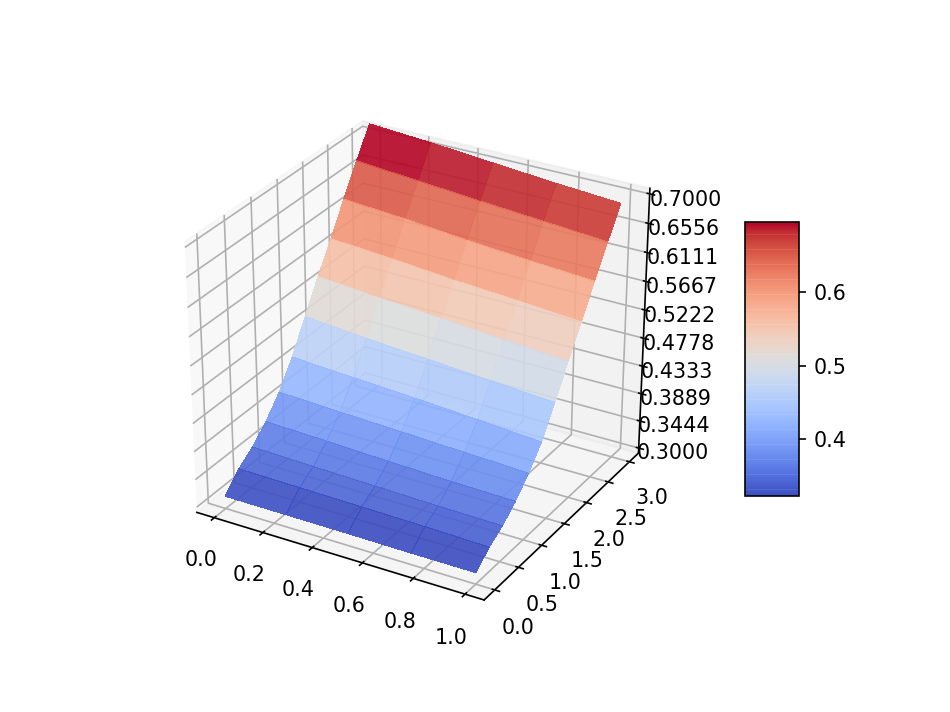

In [4]:
import json
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

res_ctc_grid = """
[{'alpha': 0.0, 'beta': 0.0, 'loss': 0.311636},
 {'alpha': 0.0, 'beta': 0.25, 'loss': 0.311277},
 {'alpha': 0.0, 'beta': 0.5, 'loss': 0.310836},
 {'alpha': 0.0, 'beta': 0.75, 'loss': 0.310061},
 {'alpha': 0.0, 'beta': 1.0, 'loss': 0.309971},
 {'alpha': 0.2727, 'beta': 0.0, 'loss': 0.337603},
 {'alpha': 0.2727, 'beta': 0.25, 'loss': 0.336121},
 {'alpha': 0.2727, 'beta': 0.5, 'loss': 0.334647},
 {'alpha': 0.2727, 'beta': 0.75, 'loss': 0.333175},
 {'alpha': 0.2727, 'beta': 1.0, 'loss': 0.330678},
 {'alpha': 0.5455, 'beta': 0.0, 'loss': 0.354929},
 {'alpha': 0.5455, 'beta': 0.25, 'loss': 0.351842},
 {'alpha': 0.5455, 'beta': 0.5, 'loss': 0.349478},
 {'alpha': 0.5455, 'beta': 0.75, 'loss': 0.346931},
 {'alpha': 0.5455, 'beta': 1.0, 'loss': 0.345404},
 {'alpha': 0.8182, 'beta': 0.0, 'loss': 0.378166},
 {'alpha': 0.8182, 'beta': 0.25, 'loss': 0.374818},
 {'alpha': 0.8182, 'beta': 0.5, 'loss': 0.370703},
 {'alpha': 0.8182, 'beta': 0.75, 'loss': 0.367445},
 {'alpha': 0.8182, 'beta': 1.0, 'loss': 0.365319},
 {'alpha': 1.0909, 'beta': 0.0, 'loss': 0.408276},
 {'alpha': 1.0909, 'beta': 0.25, 'loss': 0.40374},
 {'alpha': 1.0909, 'beta': 0.5, 'loss': 0.399829},
 {'alpha': 1.0909, 'beta': 0.75, 'loss': 0.395531},
 {'alpha': 1.0909, 'beta': 1.0, 'loss': 0.391312},
 {'alpha': 1.3636, 'beta': 0.0, 'loss': 0.447612},
 {'alpha': 1.3636, 'beta': 0.25, 'loss': 0.441499},
 {'alpha': 1.3636, 'beta': 0.5, 'loss': 0.43611},
 {'alpha': 1.3636, 'beta': 0.75, 'loss': 0.429277},
 {'alpha': 1.3636, 'beta': 1.0, 'loss': 0.422366},
 {'alpha': 1.6364, 'beta': 0.0, 'loss': 0.495662},
 {'alpha': 1.6364, 'beta': 0.25, 'loss': 0.487108},
 {'alpha': 1.6364, 'beta': 0.5, 'loss': 0.480442},
 {'alpha': 1.6364, 'beta': 0.75, 'loss': 0.473319},
 {'alpha': 1.6364, 'beta': 1.0, 'loss': 0.466259},
 {'alpha': 1.9091, 'beta': 0.0, 'loss': 0.542722},
 {'alpha': 1.9091, 'beta': 0.25, 'loss': 0.534454},
 {'alpha': 1.9091, 'beta': 0.5, 'loss': 0.52769},
 {'alpha': 1.9091, 'beta': 0.75, 'loss': 0.51971},
 {'alpha': 1.9091, 'beta': 1.0, 'loss': 0.512942},
 {'alpha': 2.1818, 'beta': 0.0, 'loss': 0.586767},
 {'alpha': 2.1818, 'beta': 0.25, 'loss': 0.57981},
 {'alpha': 2.1818, 'beta': 0.5, 'loss': 0.571334},
 {'alpha': 2.1818, 'beta': 0.75, 'loss': 0.564938},
 {'alpha': 2.1818, 'beta': 1.0, 'loss': 0.557303},
 {'alpha': 2.4545, 'beta': 0.0, 'loss': 0.63329},
 {'alpha': 2.4545, 'beta': 0.25, 'loss': 0.626387},
 {'alpha': 2.4545, 'beta': 0.5, 'loss': 0.617383},
 {'alpha': 2.4545, 'beta': 0.75, 'loss': 0.609868},
 {'alpha': 2.4545, 'beta': 1.0, 'loss': 0.603586},
 {'alpha': 2.7273, 'beta': 0.0, 'loss': 0.678383},
 {'alpha': 2.7273, 'beta': 0.25, 'loss': 0.670241},
 {'alpha': 2.7273, 'beta': 0.5, 'loss': 0.662427},
 {'alpha': 2.7273, 'beta': 0.75, 'loss': 0.655168},
 {'alpha': 2.7273, 'beta': 1.0, 'loss': 0.647649},
 {'alpha': 3.0, 'beta': 0.0, 'loss': 0.720966},
 {'alpha': 3.0, 'beta': 0.25, 'loss': 0.714281},
 {'alpha': 3.0, 'beta': 0.5, 'loss': 0.705791},
 {'alpha': 3.0, 'beta': 0.75, 'loss': 0.697558},
 {'alpha': 3.0, 'beta': 1.0, 'loss': 0.690784}]
""".replace("'", '"')

res_ctc_grid = json.loads(res_ctc_grid)
alpha_start, alpha_end, num_alpha = 0.0, 3.0, 12
beta_start, beta_end, num_beta = 0.0, 1.0, 5
cand_alphas = np.linspace(alpha_start, alpha_end, num_alpha)
cand_betas = np.linspace(beta_start, beta_end, num_beta)
cand_alphas, cand_betas = np.meshgrid(cand_alphas, cand_betas)
losses = np.array([res['loss'] for res in res_ctc_grid]).reshape([12, 5]).T

# plot the results
best_res_idx = np.argmin([res['loss'] for res in res_ctc_grid])
print('All done, the best result for grid research is: {} when alpha={} and beta={}.'.format(
    res_ctc_grid[best_res_idx]['loss'],
    res_ctc_grid[best_res_idx]['alpha'],
    res_ctc_grid[best_res_idx]['beta']
))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(cand_betas,
                       cand_alphas,
                       losses,
                       cmap=cm.coolwarm, alpha=0.9,
                       linewidth=0, antialiased=False)
ax.set_zlim(0.3, 0.7)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.04f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
# 全部导入内存，批处理，然后计算编辑距离并归一化
# 1. best path greedy 2. CTC beam search with n-gram LM (grid search for hyperparameters)
# 3. replace n-gram LM in CTC beam search with XLNet
# 4. 复现 Transormfer-based spell corrector

import h5py
from PIL import Image
import os
from time import time
# 选用归一化后的编辑距离作为 evaluation metric
from Levenshtein import distance as levenshtein_distance
# model
from crnn.network_torch import CRNN
from crnn.keys import alphabetChinese as alphabet
from config import ocrModelTorchLstm as ocrModel
import random
import swig_decoders
import numpy as np
from torch.nn.functional import softmax

GPUID = 2
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)
s_t = time()
nclass = len(alphabet) + 1
GPU = True
LSTMFLAG = True
ctc_buffer_size = 20
alphabet_list = [c for c in alphabet]
crnn = CRNN(32, 1, nclass, 256, leakyRelu=False, lstmFlag=LSTMFLAG, GPU=GPU, alphabet=alphabet,
            vertical_text=False)
crnn.load_weights(ocrModel)
print('Load model done in {:.4f}s.'.format(time() - s_t))
s_t = time()
res_aux = []


class Scorer(swig_decoders.Scorer):
    def __init__(self, alpha, beta, model_path, vocabulary):
        swig_decoders.Scorer.__init__(self, alpha, beta, model_path, vocabulary)


def ctc_beam_search_decoder_batch_pred(probs_split,
                                      vocabulary,
                                      beam_size,
                                      num_processes,
                                      cutoff_prob=1.0,
                                      cutoff_top_n=40,
                                      ext_scoring_func=None):
    probs_split = [probs.tolist() for probs in probs_split]

    batch_beam_results = swig_decoders.ctc_beam_search_decoder_batch(
        probs_split, vocabulary, beam_size, num_processes, cutoff_prob,
        cutoff_top_n, ext_scoring_func)
    return [result[0][1] for result in batch_beam_results]


def levenshtein_distance_norm(true_text, pred_text, debug=True):
    '''
    归一化的编辑距离, 越小越好
    @return [0, 1]
    '''
    if debug:
        res_aux.append([true_text, pred_text])
    max_len = max(len(true_text), len(pred_text), 1)
    return levenshtein_distance(true_text, pred_text) / max_len


# 因为数据规模不大，所以直接全部加载到内存
dataset_boxes = []
with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    print('Loading dataset into memory.')
    for img in f:
        # 暂时只考虑水平文本行
        if not bool(f[img]['vertical'][...]):
#             if len(dataset_boxes) >= 1 * 256 * 10:
#                 break
            dataset_boxes.append({
                # 灰度图
                'img': Image.fromarray(f[img]['img'][...]).convert('RGB').convert('L'),
                # 标签
                'true_text': str(f[img]['txt'][...])
            })
print('Dataset loaded, #sample={}, took {:.4f}s.'.format(len(dataset_boxes), time() - s_t))
dataset_boxes = random.sample(dataset_boxes, len(dataset_boxes) // 24)
print('Randomly sample 1/24 from dataset: {} samples.'.format(len(dataset_boxes)))

# inference
boxes, losses, loss_total = crnn.predict_batch(dataset_boxes, batch_size=1, evaluation_per_batch=1000,
                                               evaluation_metric=levenshtein_distance_norm)
res_aux_greedy = res_aux
res_aux = []

ctc_beam_lm_decoder = lambda raw_preds: ctc_beam_search_decoder_batch_pred(
        probs_split=[softmax(raw_pred, dim=1) for raw_pred in raw_preds],
        vocabulary=alphabet_list,
        beam_size=10,
        num_processes=ctc_buffer_size,
        ext_scoring_func=None,
        cutoff_prob=1.0,
        cutoff_top_n=50)
boxes, losses, loss_total = crnn.predict_batch(dataset_boxes, batch_size=1, evaluation_per_batch=1000,
                                               evaluation_metric=levenshtein_distance_norm,
                                               ctc_beam_lm_decoder=ctc_beam_lm_decoder,
                                               ctc_buffer_size=ctc_buffer_size)
res_aux_ctc = res_aux
res_aux = []


scorer = Scorer(alpha=0., beta=1., model_path=os.path.join('/data/xiaowentao/chineseocr',
                                                                 'models/zh_giga.no_cna_cmn.prune01244.klm'),
                    vocabulary=alphabet_list)
ctc_beam_lm_decoder = lambda raw_preds: ctc_beam_search_decoder_batch_pred(
        probs_split=[softmax(raw_pred, dim=1) for raw_pred in raw_preds],
        vocabulary=alphabet_list,
        beam_size=10,
        num_processes=ctc_buffer_size,
        ext_scoring_func=scorer,
        cutoff_prob=1.0,
        cutoff_top_n=50)
boxes, losses, loss_total = crnn.predict_batch(dataset_boxes, batch_size=1, evaluation_per_batch=1000,
                                               evaluation_metric=levenshtein_distance_norm,
                                               ctc_beam_lm_decoder=ctc_beam_lm_decoder,
                                               ctc_buffer_size=ctc_buffer_size)
res_aux_ctc_lm = res_aux
res_aux = []

Load model done in 9.9053s.
Loading dataset into memory.


In [14]:
from Levenshtein import editops


for i in range(100, 120):
    print('Example of editops:', [res_aux_greedy[i][1], res_aux_greedy[i][0]],
          editops(res_aux_greedy[i][1], res_aux_greedy[i][0]))

stat_greedy, stat_ctc, stat_ctc_lm = {'ops': 0}, {'ops': 0}, {'ops': 0}

for r in res_aux_greedy:
    # editops from pred text to true text
    ops = editops(r[1], r[0])
    for o in ops:
        stat_greedy['ops'] += 1
        if o[0] not in stat_greedy:
            stat_greedy[o[0]] = 1
        else:
            stat_greedy[o[0]] += 1

for r in res_aux_ctc:
    ops = editops(r[1], r[0])
    for o in ops:
        stat_ctc['ops'] += 1
        if o[0] not in stat_ctc:
            stat_ctc[o[0]] = 1
        else:
            stat_ctc[o[0]] += 1
            
for r in res_aux_ctc_lm:
    ops = editops(r[1], r[0])
    for o in ops:
        stat_ctc_lm['ops'] += 1
        if o[0] not in stat_ctc_lm:
            stat_ctc_lm[o[0]] = 1
        else:
            stat_ctc_lm[o[0]] += 1

# 从结果可以看出来，三种编码器的错误都主要集中在 replace，其实是 insert，最后才是 delete
# 并且 ctc with lm 会造成更多的 delete 错误，也就是说，编码出来的文本会更加长一点
print('edit ops statistic:\n greedy:\n{}\n\nctc:\n{}\n\nctc with lm:\n{}\n'.format(
    stat_greedy, stat_ctc, stat_ctc_lm))

NameError: name 'res_aux_greedy' is not defined

In [4]:
!nvidia-smi && uptime && free -h

Sat Apr  4 09:57:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.14       Driver Version: 430.14       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0  On |                  N/A |
| 22%   24C    P8    13W / 250W |     51MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:3B:00.0  On |                  N/A |
| 22%   36C    P2    59W / 250W |   4694MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G